# 03_MLP-Growth-Prune-Synapses

Decision to grow or prune. For $d \sim \text{Bern}(\epsilon_i)$. We set a priori the number of training cycles $n$. So we set $\epsilon_i = \epsilon_{i - 1} - 1/n$

$$A_i = \begin{cases}
\text{RandExpand}(A_{i-1}) & d=0 \\
\text{ActivityPrune}(A_{i-1}) & d=1 \\
\end{cases}$$

Hypter parameter $\gamma$ to control grow and pruning.
$$|\text{RandExpand}(A_{i})| = |A_{i - 1}| + \gamma$$
$$|\text{ActivityPrune}(A_{i})| = |A_{i - 1}| - \gamma$$

The idea is to create an tensor attribute for the $D$ matrix. In the original text, Stothers describes using $D$ such that 1 refers to a dead neuron, and 0 for an alive one. I will change this tensor to $A$ for active. This way, 1 is alive and 0 is dead. Thus, the new forward step is:

$$y = a \cdot w \cdot x + b$$
$$Y = (A * W)X + \beta$$

Where $*$ is element wise multiplication. If $a_{i,j}$ is 0, then $dL/dw = a * x = 0 * x = 0$, so no updates will be made.

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from src.simple_pruning_growth_model import PruneGrowNetwork
from src.training_testing_loop import full_train, save_model_attr
from src.load_MNIST import load_MNIST
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_dataloader, val_dataloader, test_dataloader = load_MNIST(root='./data', subset_frac=0.1, batch_size=64)

**TODO**: should I normalize the data?

In [4]:
model = PruneGrowNetwork(gamma=0.1, init_density=0.5, num_training_iter=100)

train_losses_epoch, val_losses_epoch, test_df = full_train(
    model, train_dataloader, val_dataloader, test_dataloader,
    learning_rate = 1e-2, 
    plot=False, verbose=False
)

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]

done!


In [10]:
model_pth = './data/03.grow_prune.model.state_dict.pth'
model_pth

'./data/03.grow_prune.model.state_dict.pth'

In [11]:
torch.save(model.state_dict(), model_pth)

In [24]:
model_attr_pth = './data/03.grow_prune.model.attr.pkl'

In [23]:
save_model_attr(model, './data/03.grow_prune.model.attr.pkl')

In [26]:
import pickle

with open(model_attr_pth, 'rb') as fp:
    model_attr = pickle.load(fp)

In [12]:
training_losses_df = pd.DataFrame(train_losses_epoch).T
training_losses_df.columns.name = 'batch'
training_losses_df.index.name = 'epoch'

val_losses_df = pd.DataFrame(val_losses_epoch).T
val_losses_df.columns.name = 'batch'
val_losses_df.index.name = 'epoch'

stack_training_losses_df = training_losses_df.stack().reset_index().rename(columns={0: 'loss'})
stack_training_losses_df.index = stack_training_losses_df['epoch'].astype(str) + '-' + stack_training_losses_df['batch'].astype(str)
stack_training_losses_df.index.name = 'index'
stack_val_losses_df = val_losses_df.stack().reset_index().rename(columns={0: 'loss'})
stack_val_losses_df.index = stack_val_losses_df['epoch'].astype(str) + '-' + stack_val_losses_df['batch'].astype(str)
stack_val_losses_df.index.name = 'index'

In [14]:
training_losses_fn = './data/03.training_losses.tsv'
val_losses_fn = './data/03.val_losses.tsv'

training_losses_df.to_csv(training_losses_fn, sep='\t')
val_losses_df.to_csv(val_losses_fn, sep='\t')

# Plot performance

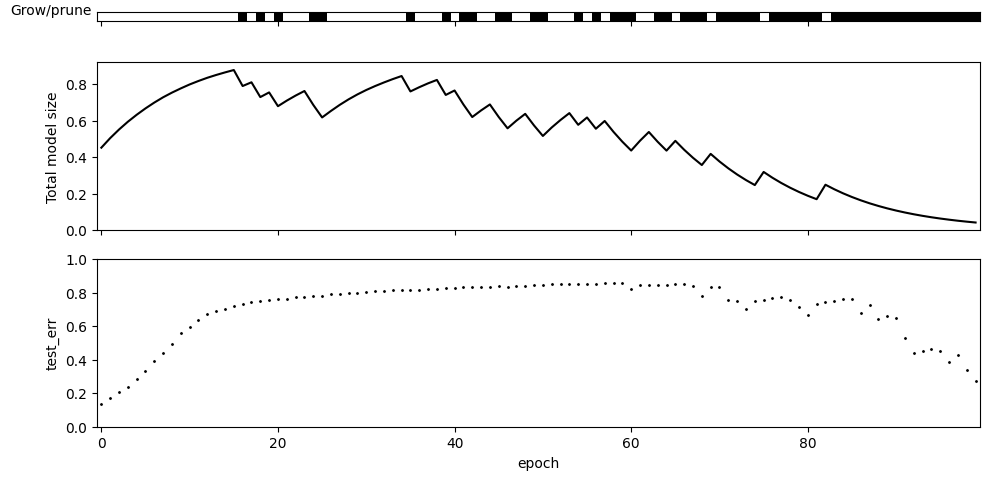

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True, height_ratios=[1, 5, 5])
axes[0].imshow(np.array(model_attr['grow_prune_history']).reshape(1, -1), cmap='gray')
axes[0].set_yticks([])
axes[0].set_ylabel("Grow/prune", rotation=0, ha='right')

axes[1].plot(np.array(model_attr['synapse_count_history']) / model.total_size, c='k') 
axes[1].set_ylabel("Total model size")

sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err', ax=axes[2], c='k', s=5) 
axes[2].set_ylim(0, 1.0)
plt.tight_layout()
plt.show()

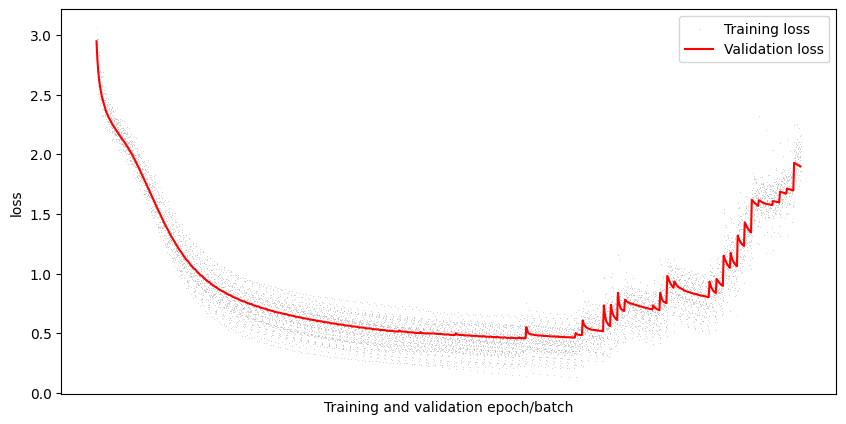

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(stack_training_losses_df.reset_index(), x='index', y='loss', label='Training loss', alpha=0.5, c='gray', s=0.5)
sns.lineplot(stack_val_losses_df.reset_index(), x='index', y='loss',  label='Validation loss', c='red')
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.show()

**TODO** Regularization or other way to determine when to stop pruning?
- Seems like we see increase loss in training and validation too

# Look at weight distribution

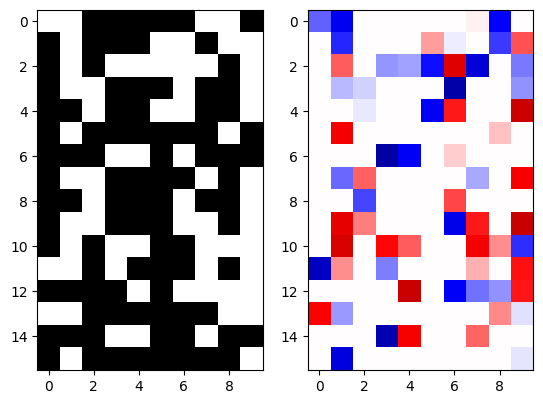

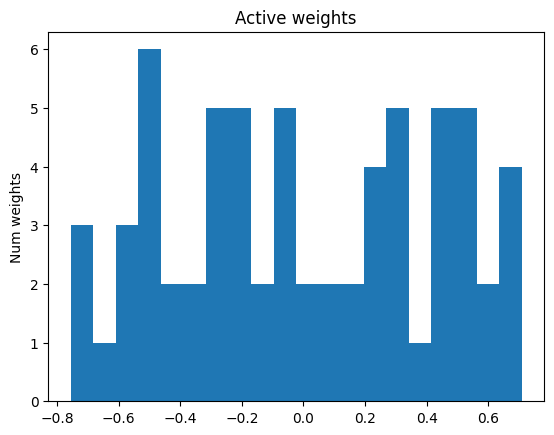

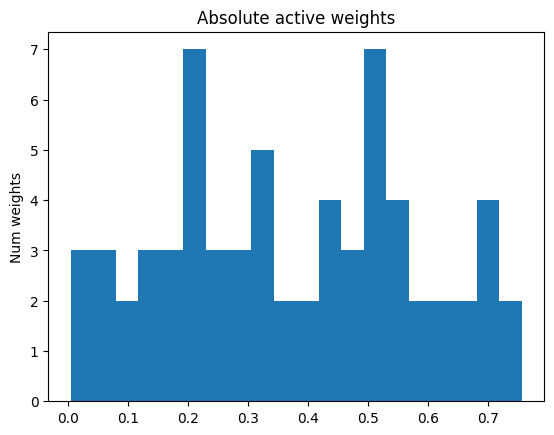

Epochs:   0%|                                                                                                                          | 0/50 [00:00<?, ?it/s]

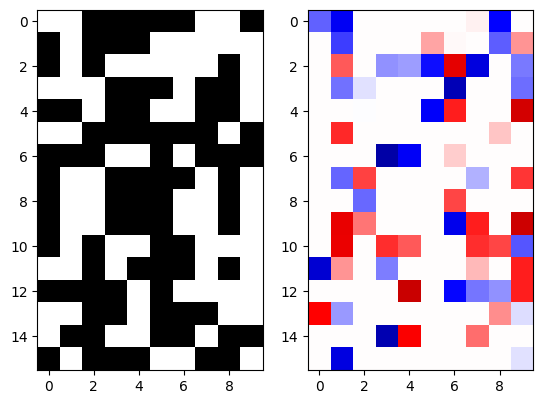

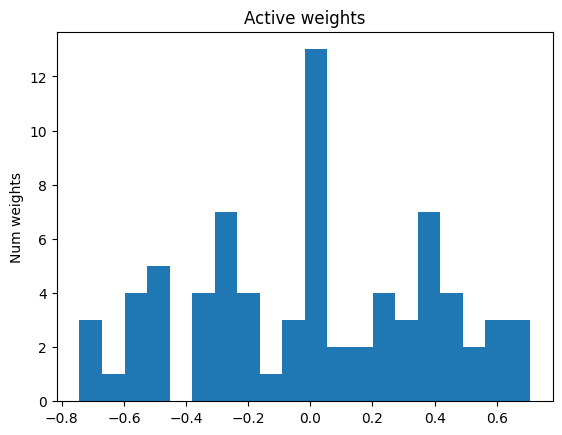

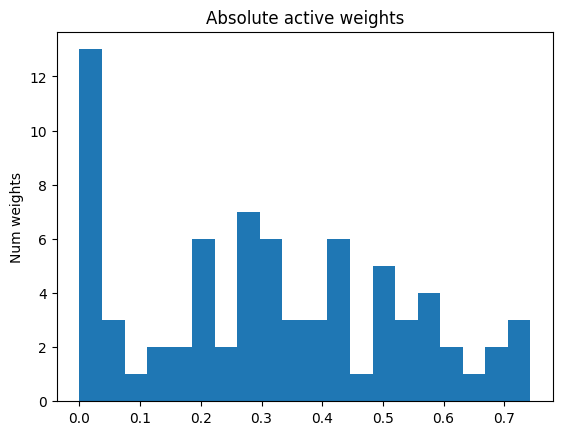

Epochs:   2%|██▎                                                                                                               | 1/50 [00:01<01:21,  1.66s/it]

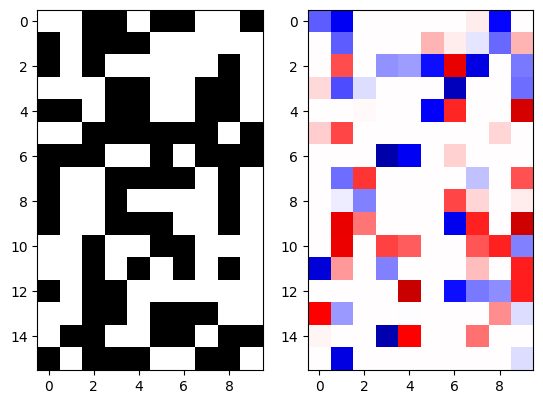

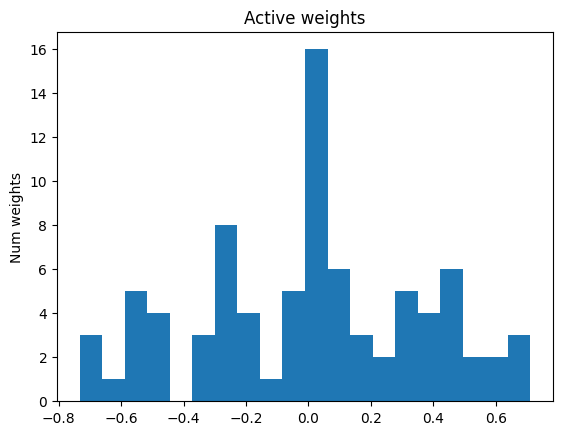

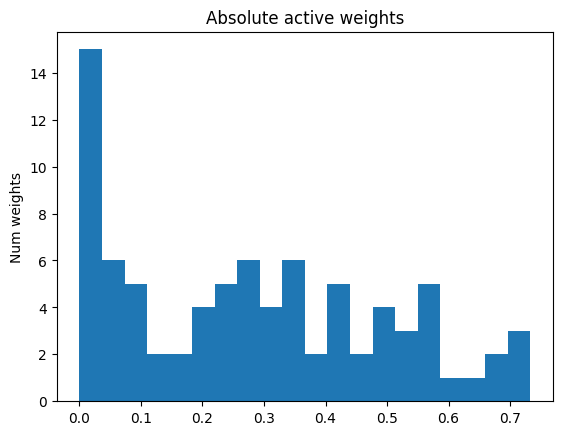

Epochs:   4%|████▌                                                                                                             | 2/50 [00:03<01:22,  1.71s/it]

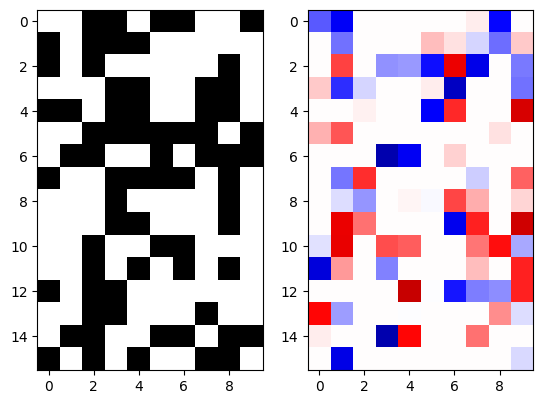

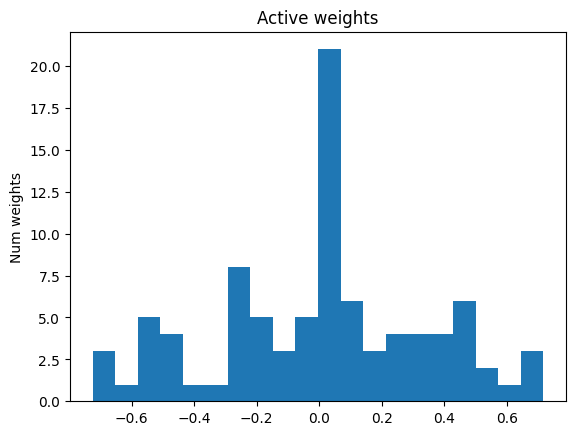

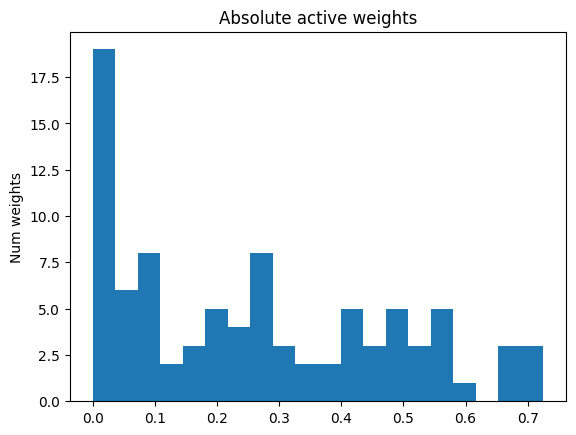

Epochs:   6%|██████▊                                                                                                           | 3/50 [00:05<01:22,  1.75s/it]

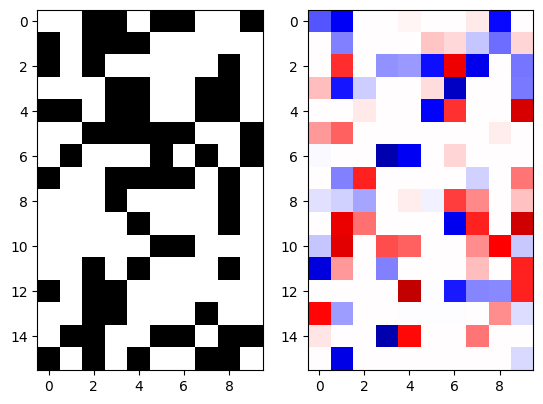

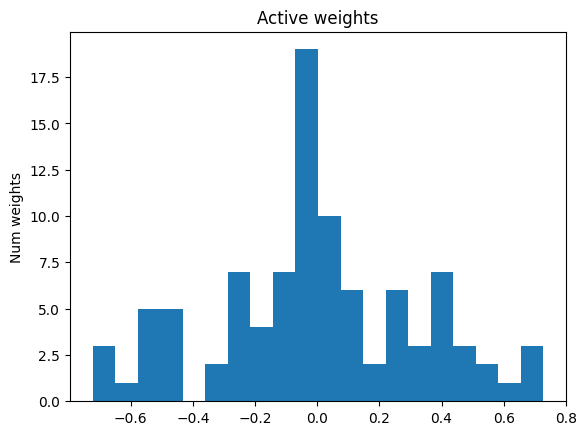

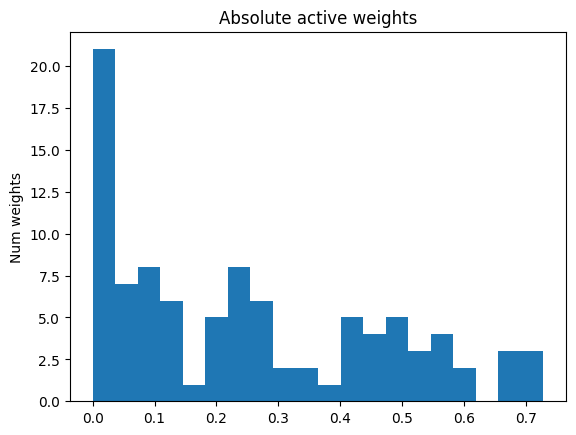

Epochs:   8%|█████████                                                                                                         | 4/50 [00:06<01:19,  1.73s/it]

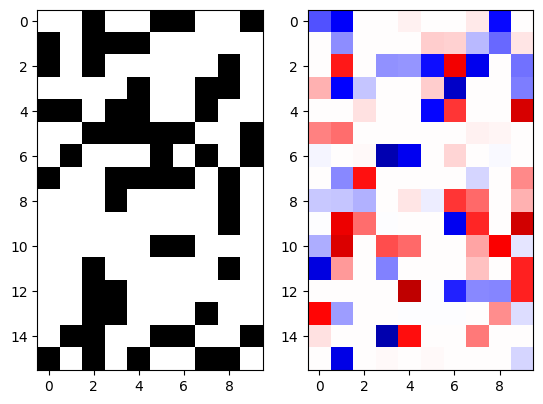

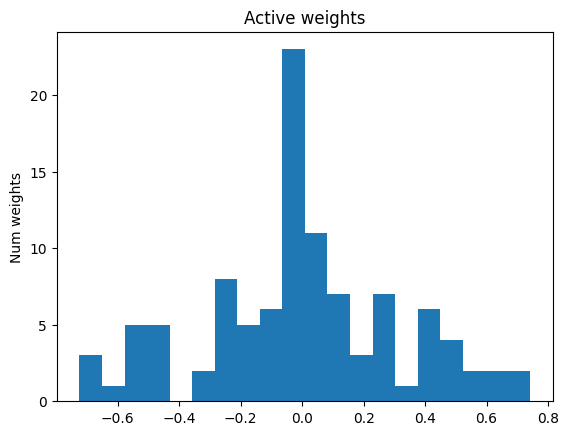

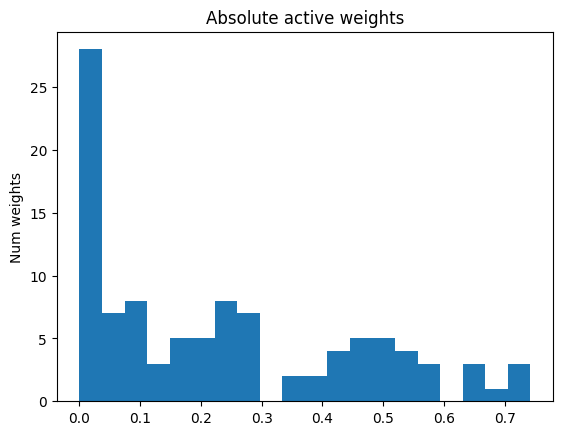

Epochs:  10%|███████████▍                                                                                                      | 5/50 [00:08<01:18,  1.75s/it]

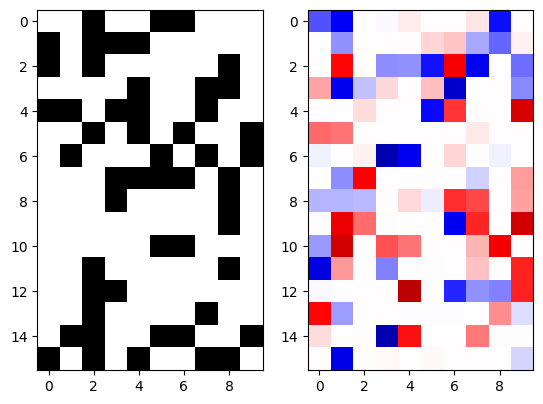

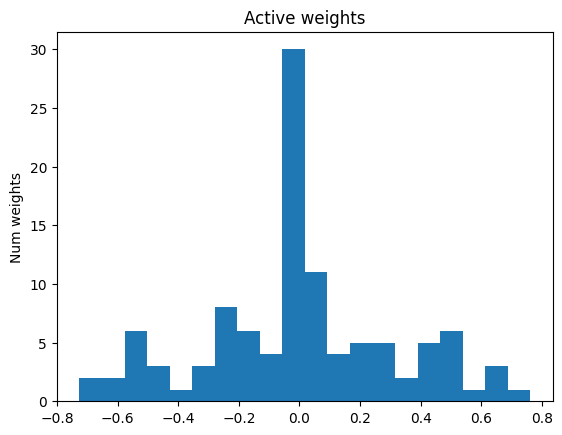

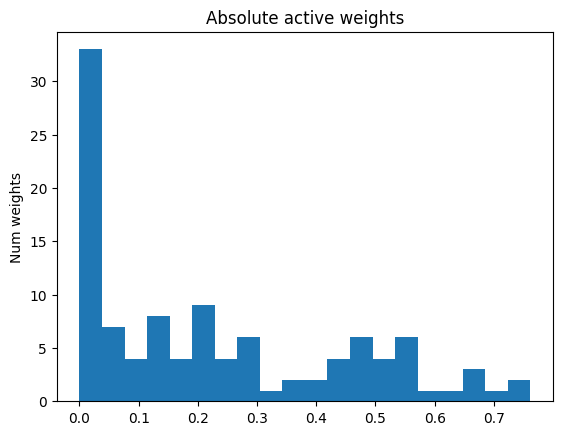

Epochs:  12%|█████████████▋                                                                                                    | 6/50 [00:11<01:27,  1.98s/it]

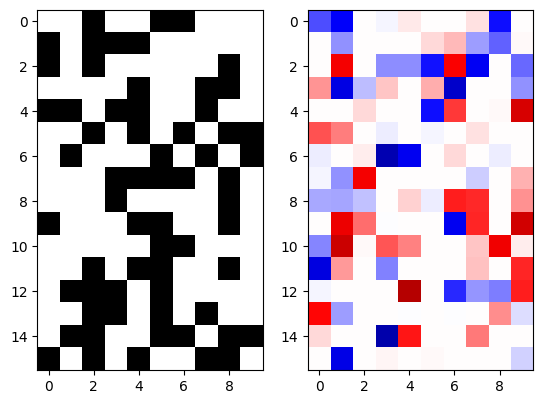

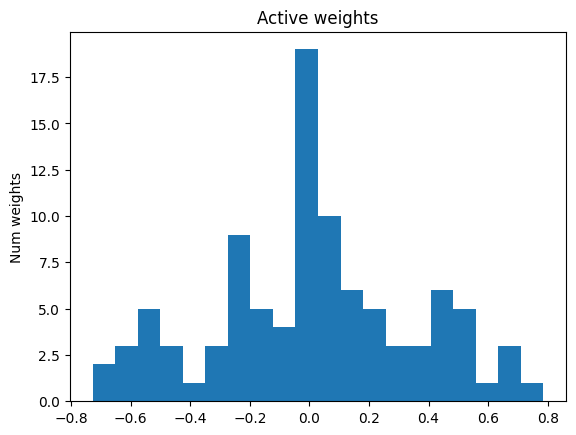

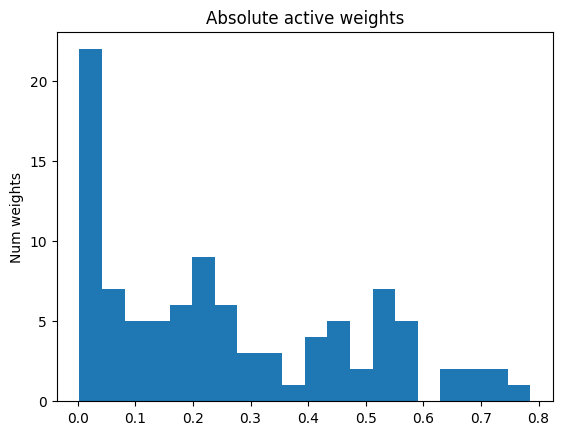

Epochs:  14%|███████████████▉                                                                                                  | 7/50 [00:12<01:23,  1.94s/it]

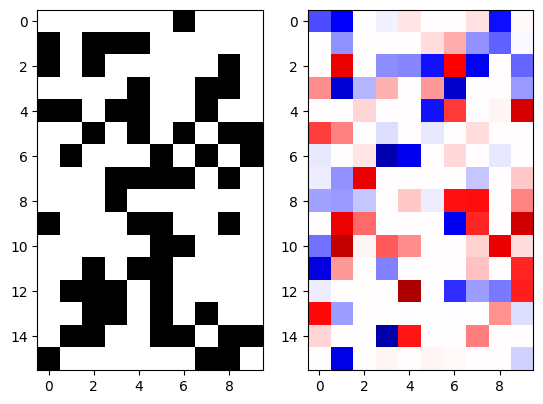

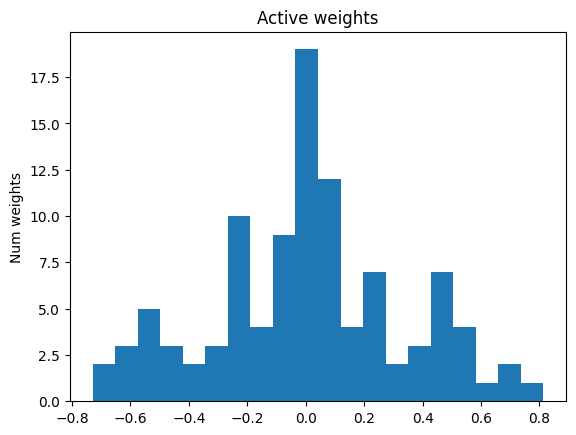

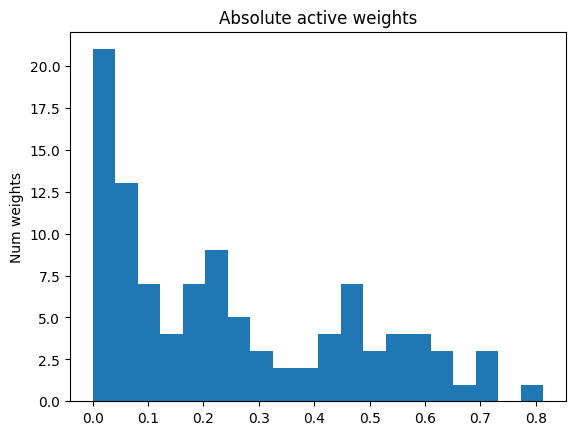

Epochs:  16%|██████████████████▏                                                                                               | 8/50 [00:15<01:27,  2.08s/it]

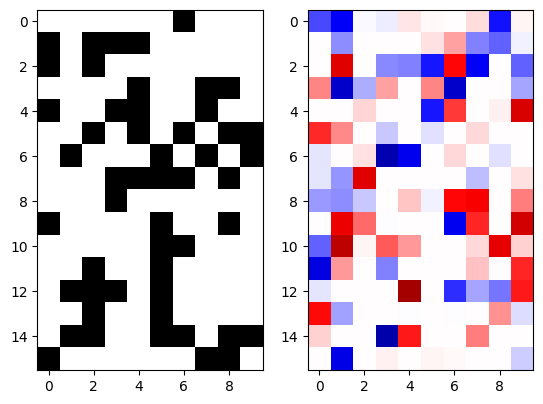

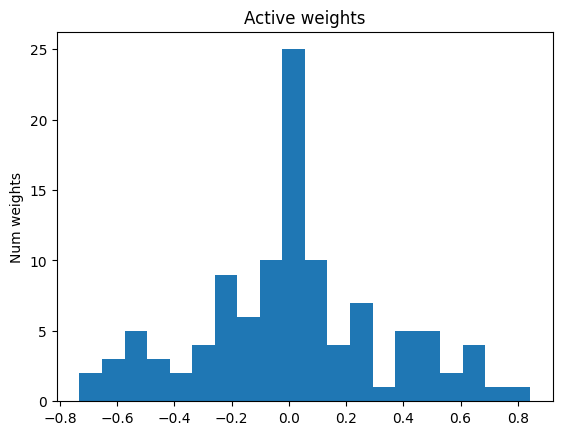

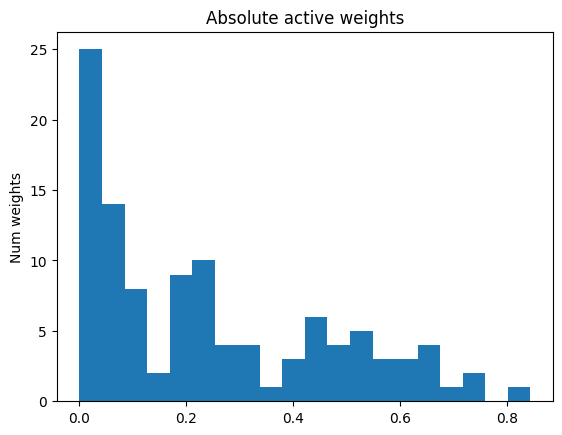

Epochs:  18%|████████████████████▌                                                                                             | 9/50 [00:17<01:27,  2.14s/it]

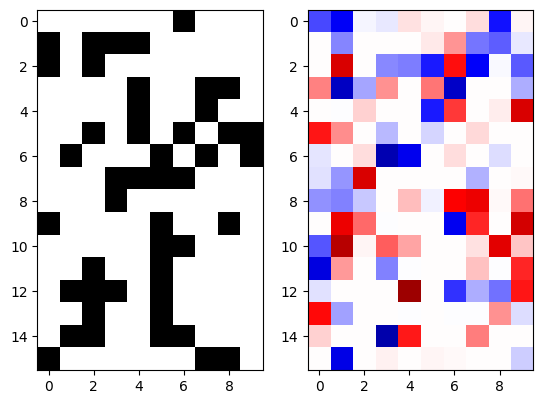

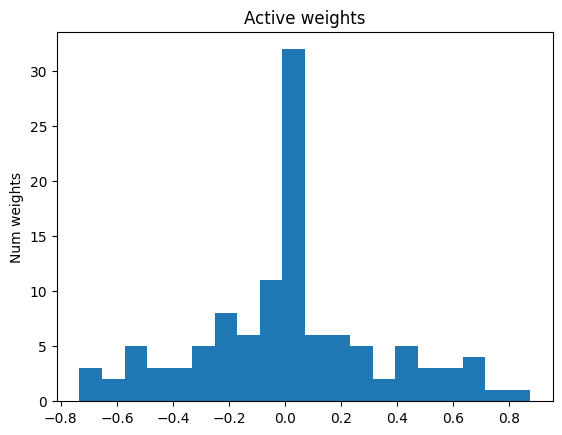

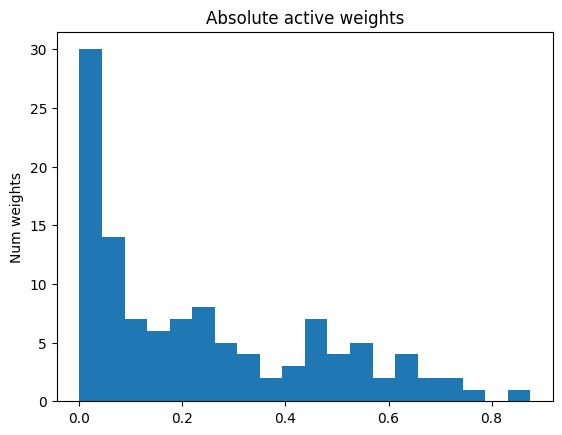

Epochs:  20%|██████████████████████▌                                                                                          | 10/50 [00:20<01:31,  2.28s/it]

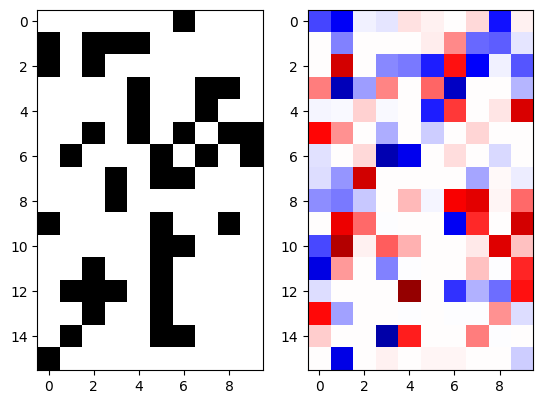

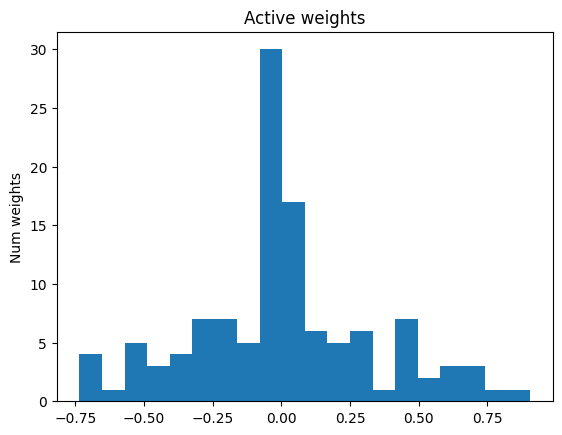

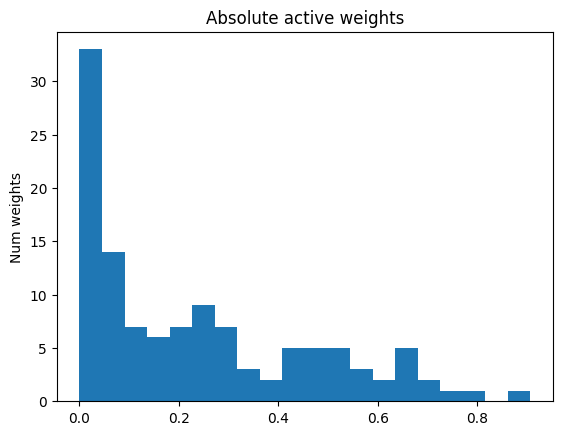

Epochs:  22%|████████████████████████▊                                                                                        | 11/50 [00:22<01:27,  2.25s/it]

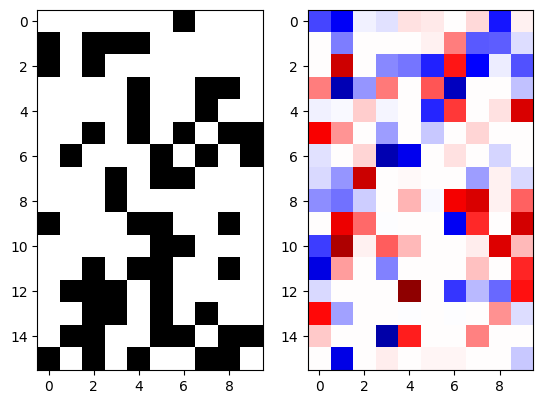

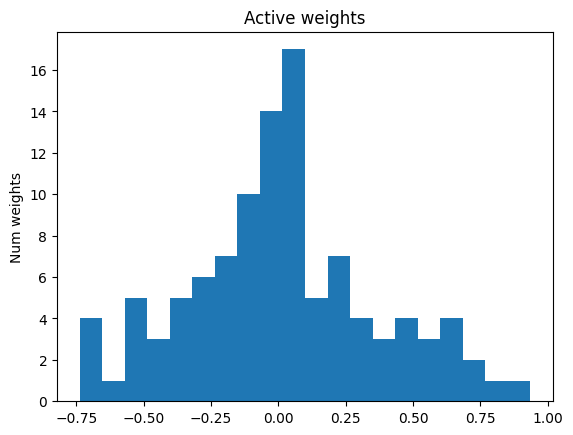

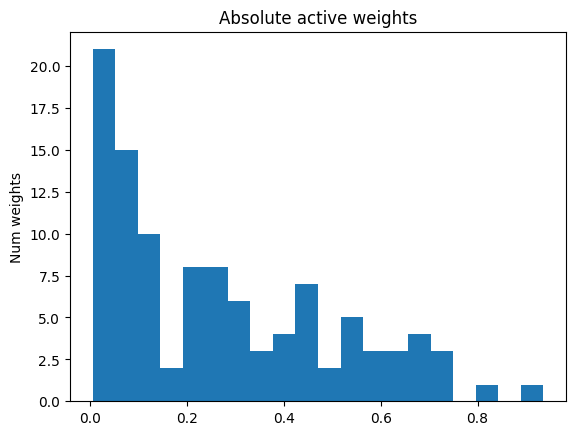

Epochs:  24%|███████████████████████████                                                                                      | 12/50 [00:24<01:21,  2.13s/it]

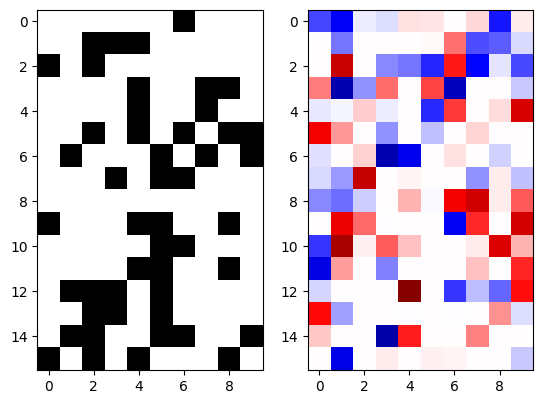

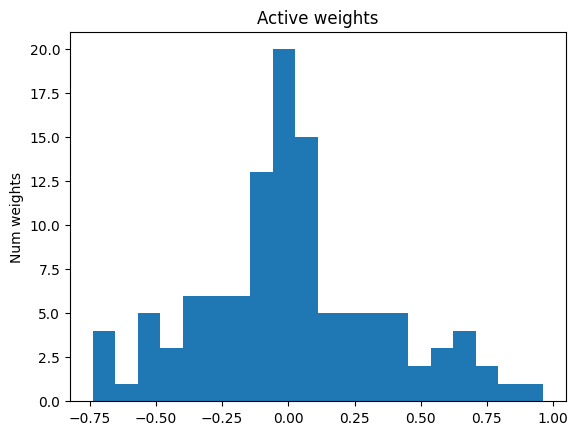

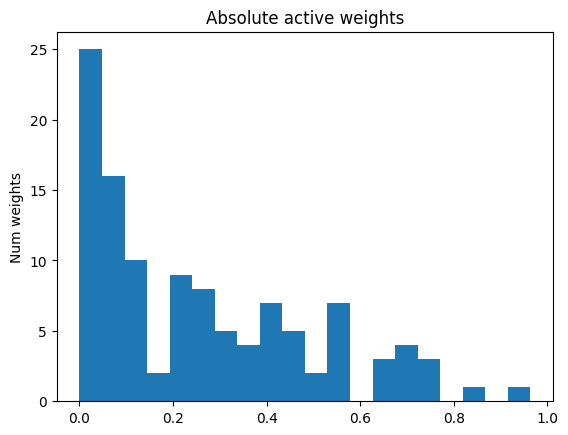

Epochs:  26%|█████████████████████████████▍                                                                                   | 13/50 [00:25<01:13,  1.99s/it]

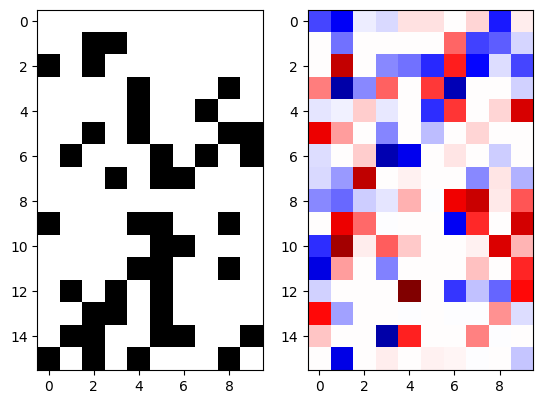

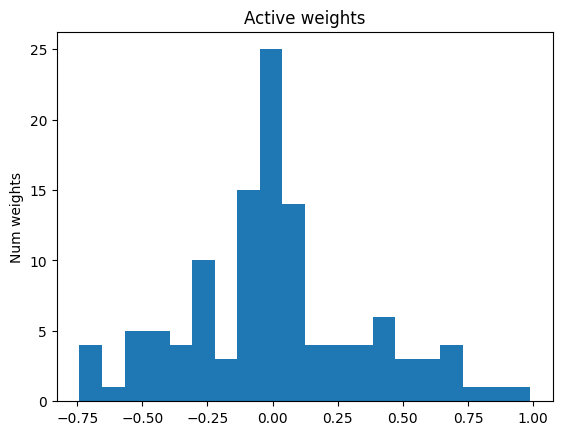

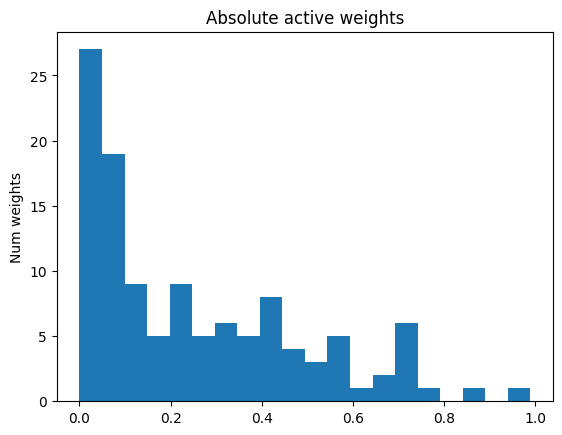

Epochs:  28%|███████████████████████████████▋                                                                                 | 14/50 [00:28<01:13,  2.04s/it]

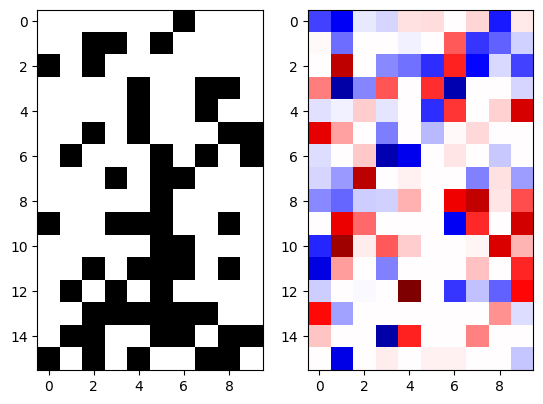

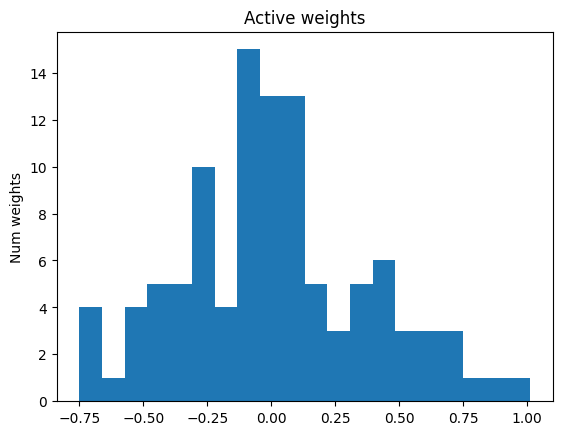

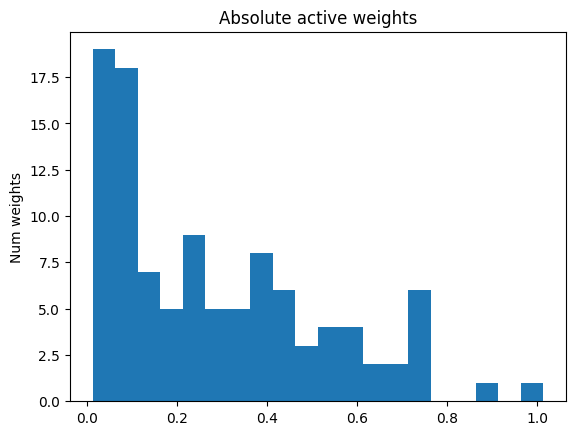

Epochs:  30%|█████████████████████████████████▉                                                                               | 15/50 [00:30<01:10,  2.02s/it]

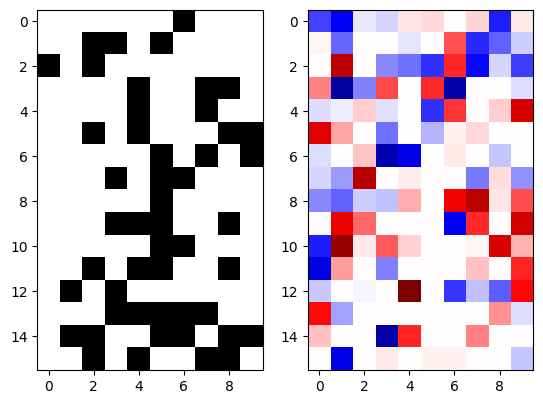

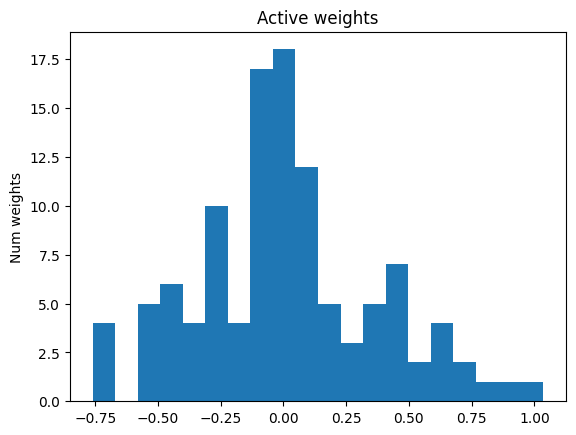

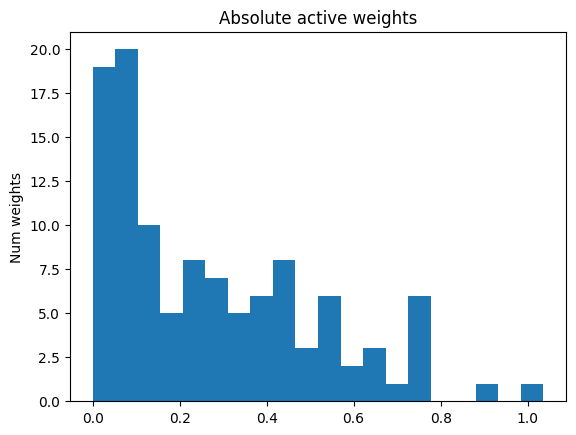

Epochs:  32%|████████████████████████████████████▏                                                                            | 16/50 [00:31<01:07,  1.99s/it]

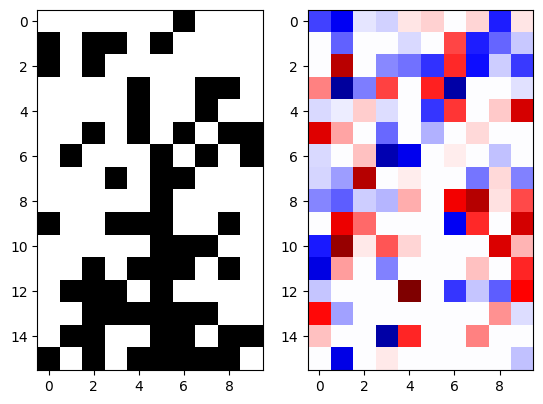

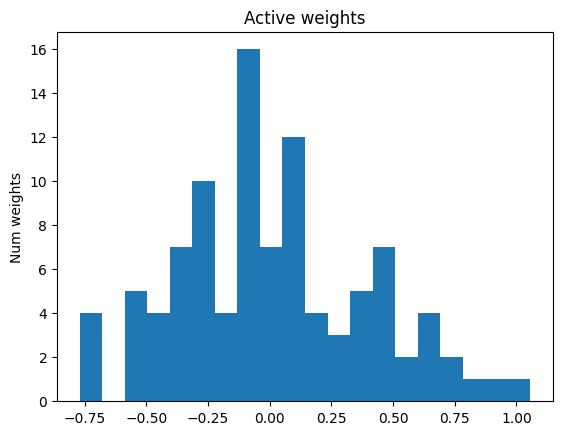

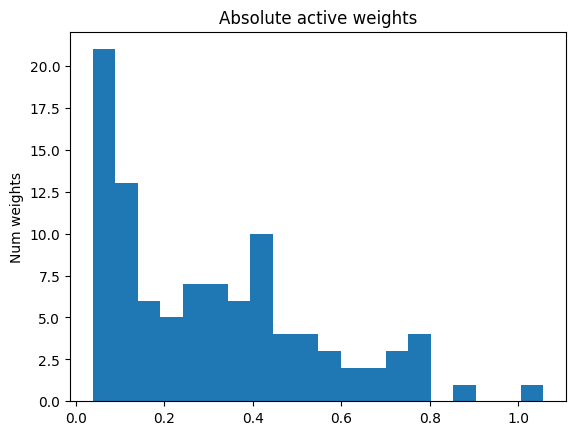

Epochs:  34%|██████████████████████████████████████▍                                                                          | 17/50 [00:33<01:03,  1.93s/it]

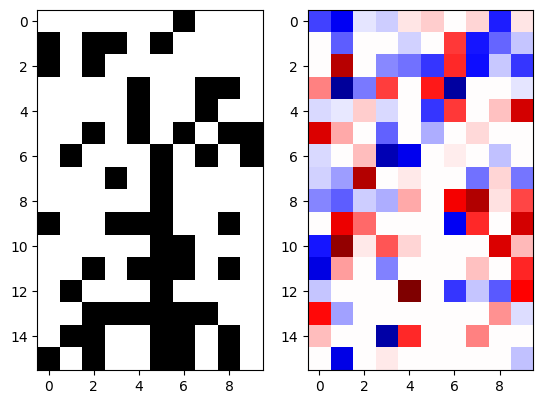

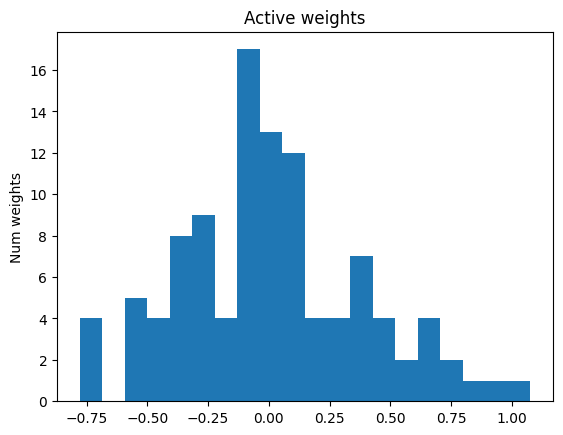

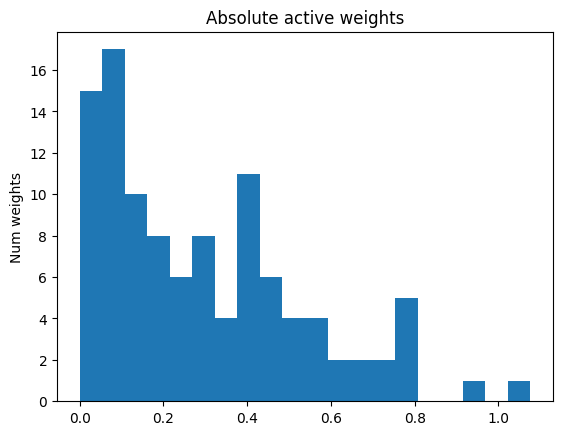

Epochs:  36%|████████████████████████████████████████▋                                                                        | 18/50 [00:35<01:00,  1.90s/it]

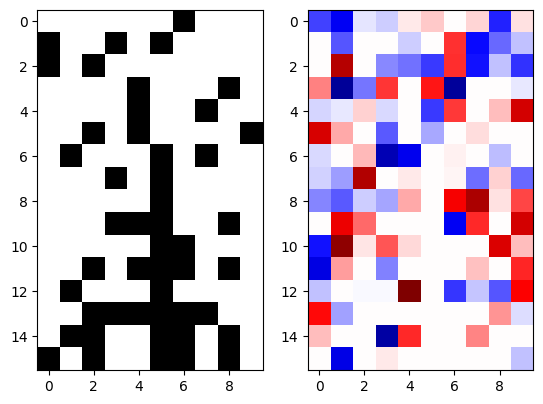

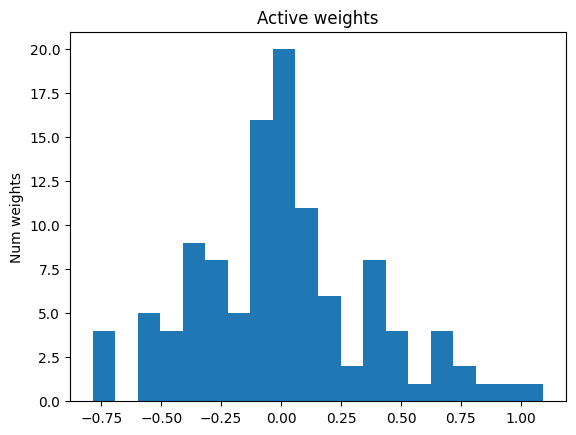

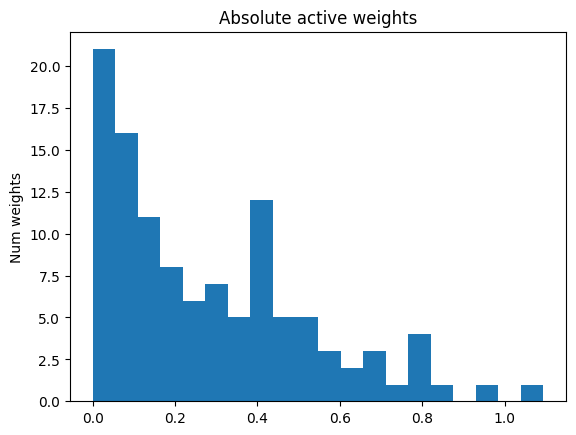

Epochs:  38%|██████████████████████████████████████████▉                                                                      | 19/50 [00:37<00:57,  1.85s/it]

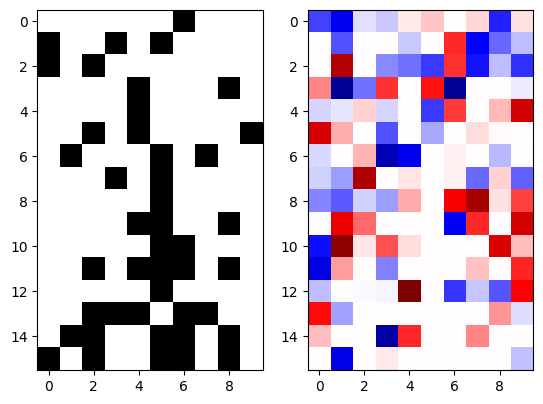

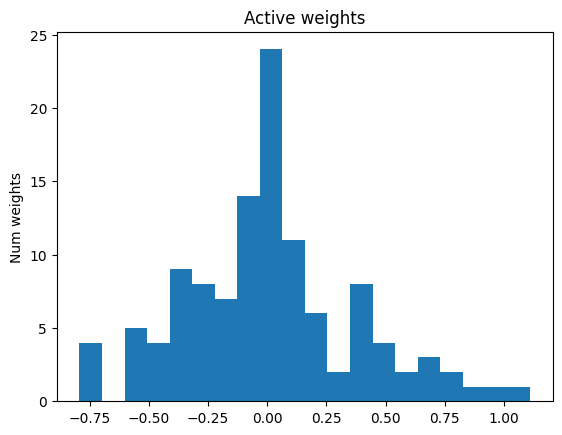

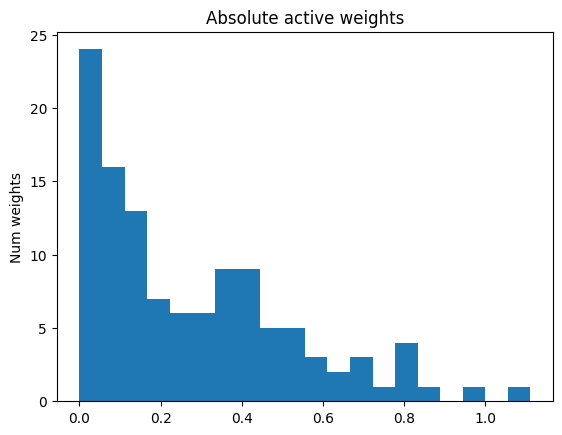

Epochs:  40%|█████████████████████████████████████████████▏                                                                   | 20/50 [00:39<00:55,  1.84s/it]

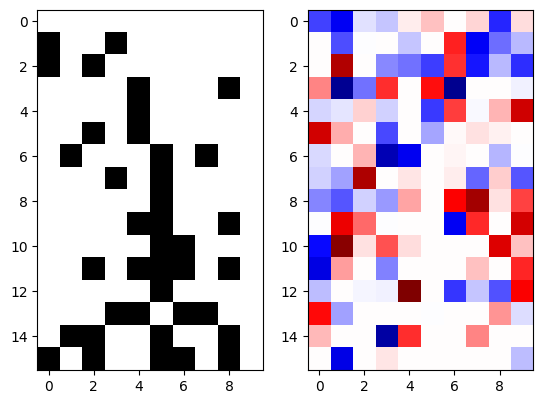

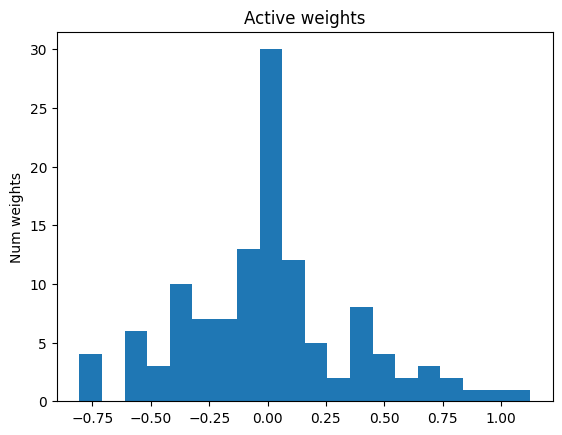

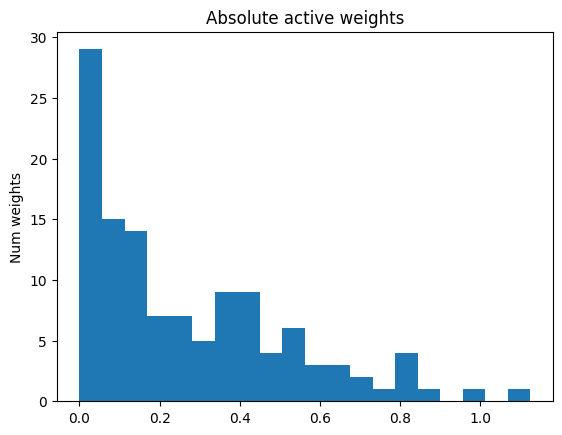

Epochs:  42%|███████████████████████████████████████████████▍                                                                 | 21/50 [00:40<00:52,  1.81s/it]

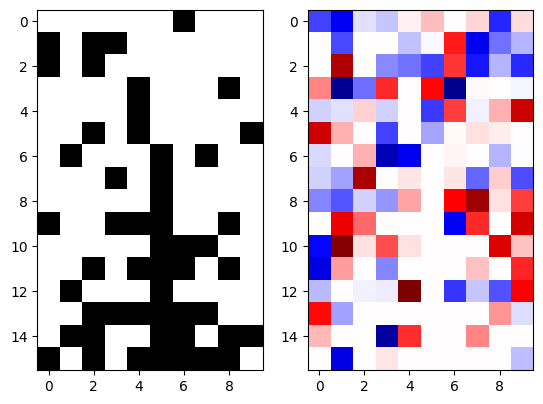

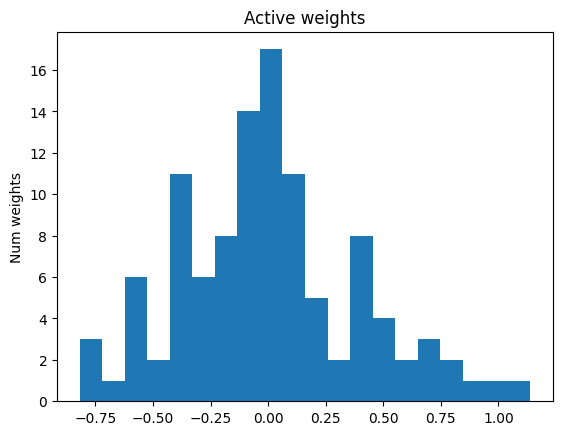

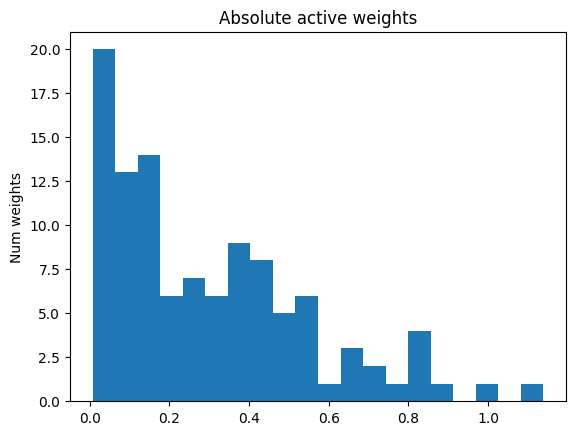

Epochs:  44%|█████████████████████████████████████████████████▋                                                               | 22/50 [00:43<00:56,  2.01s/it]

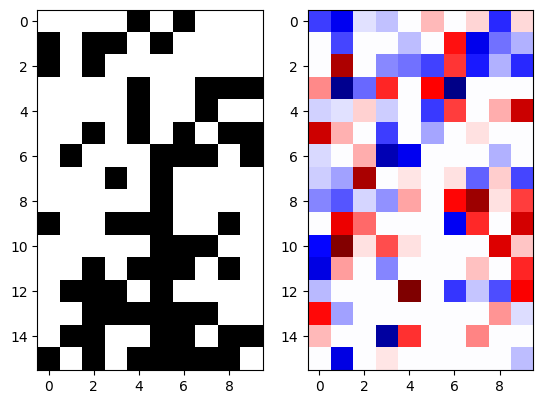

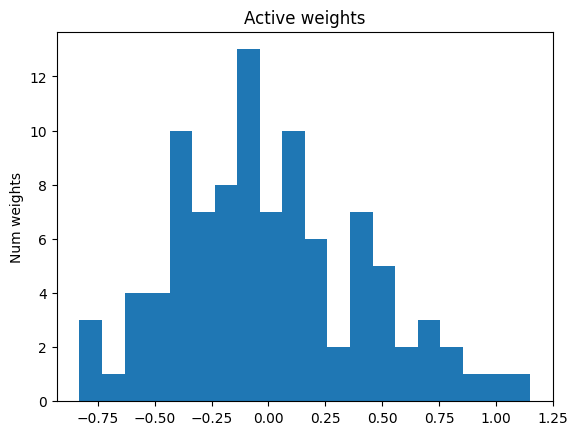

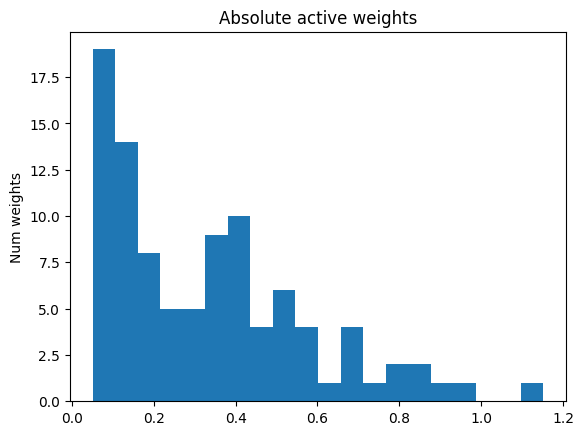

Epochs:  46%|███████████████████████████████████████████████████▉                                                             | 23/50 [00:45<00:52,  1.95s/it]

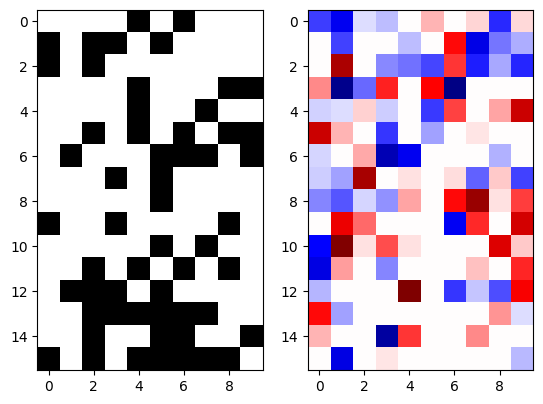

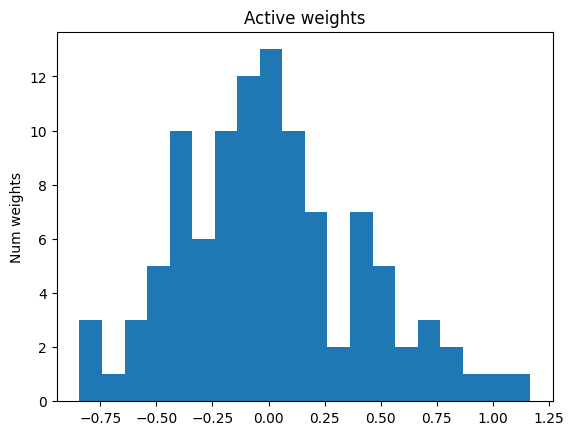

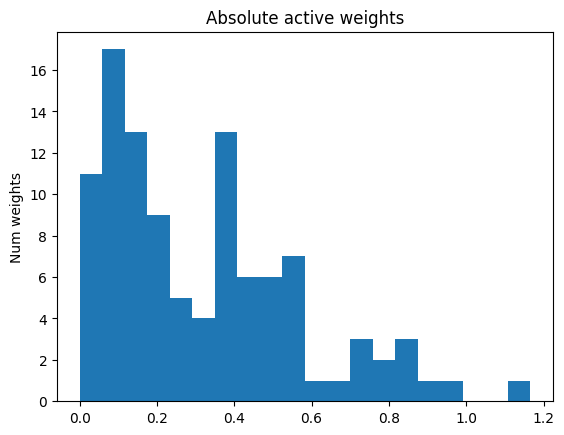

Epochs:  48%|██████████████████████████████████████████████████████▏                                                          | 24/50 [00:46<00:49,  1.90s/it]

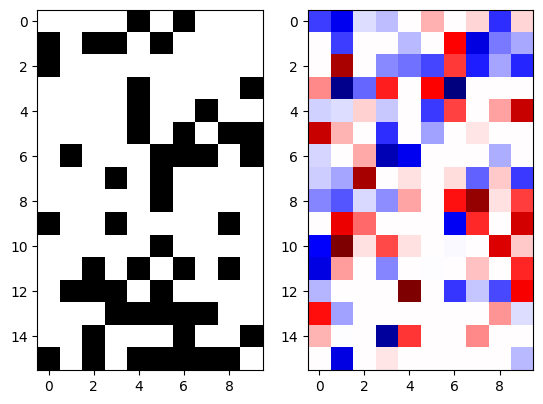

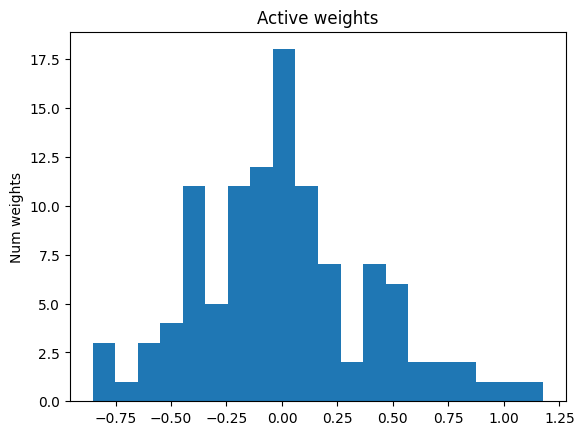

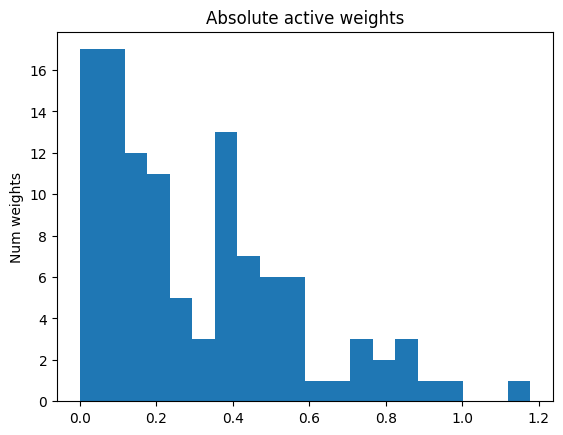

Epochs:  50%|████████████████████████████████████████████████████████▌                                                        | 25/50 [00:48<00:46,  1.86s/it]

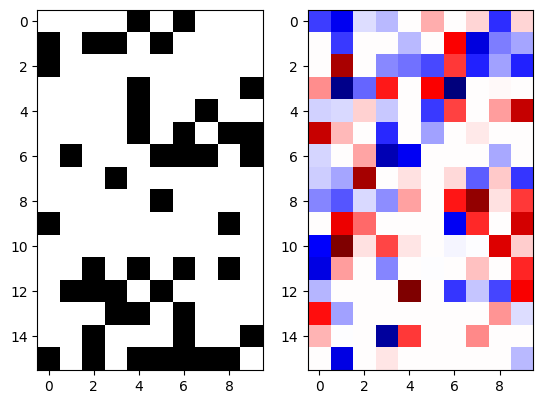

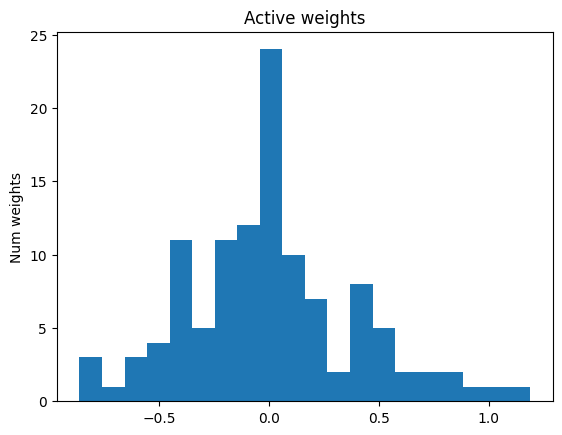

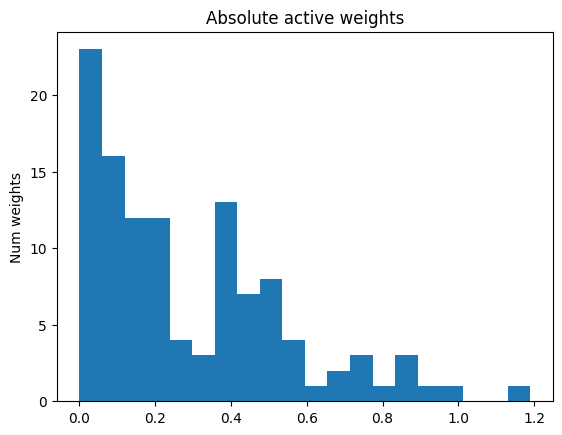

Epochs:  52%|██████████████████████████████████████████████████████████▊                                                      | 26/50 [00:50<00:43,  1.81s/it]

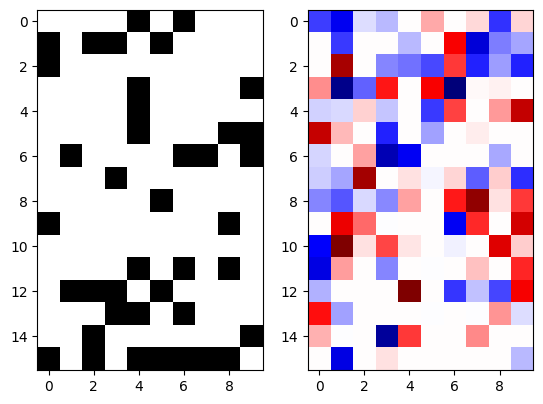

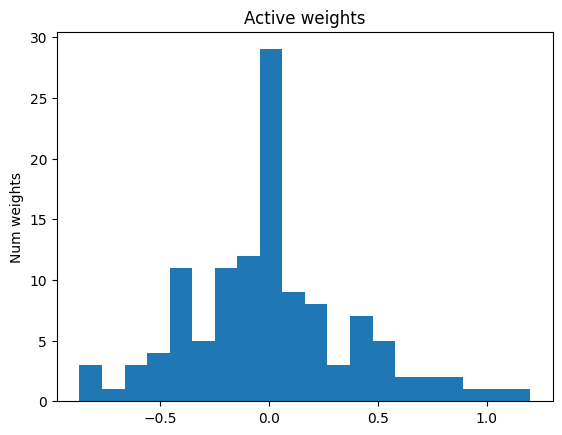

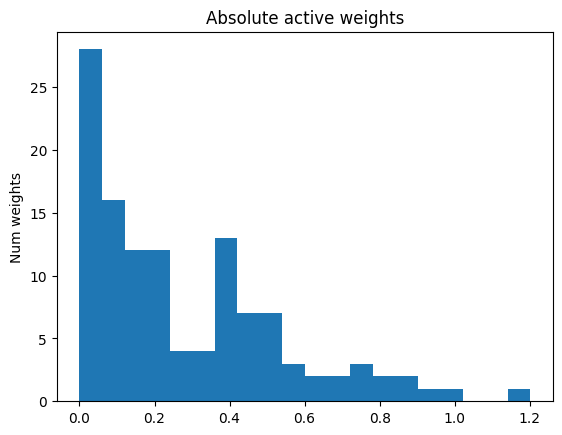

Epochs:  54%|█████████████████████████████████████████████████████████████                                                    | 27/50 [00:52<00:41,  1.79s/it]

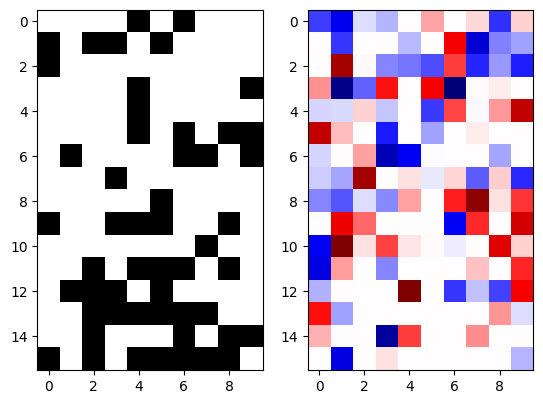

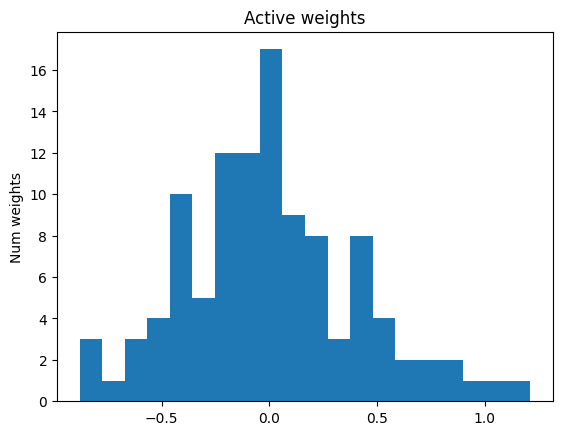

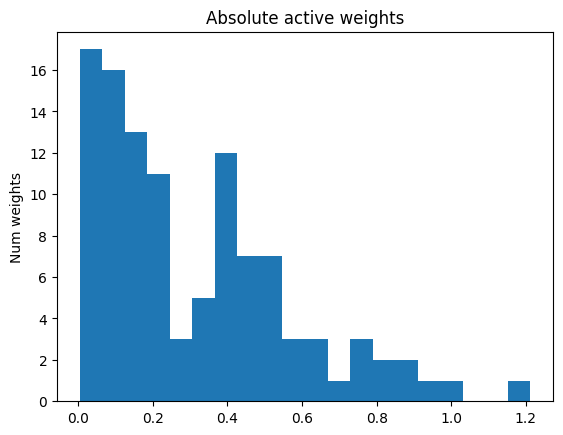

Epochs:  56%|███████████████████████████████████████████████████████████████▎                                                 | 28/50 [00:53<00:39,  1.80s/it]

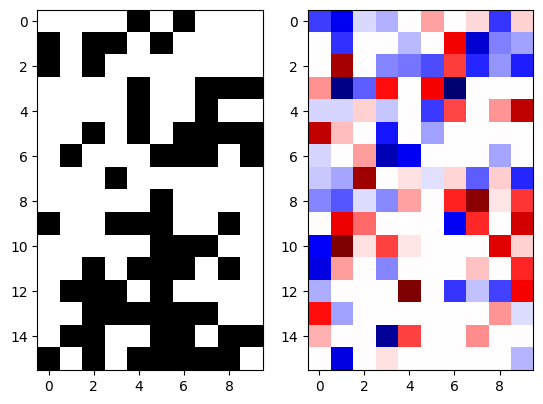

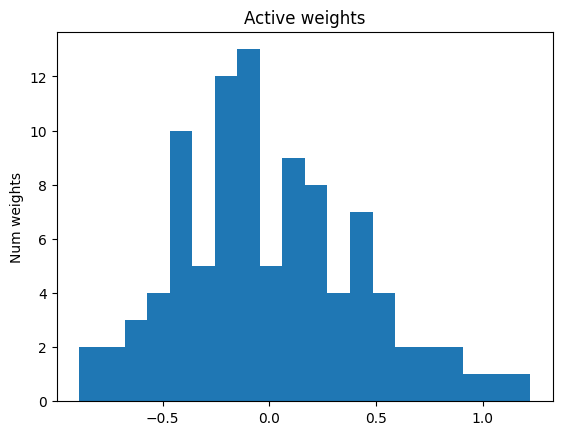

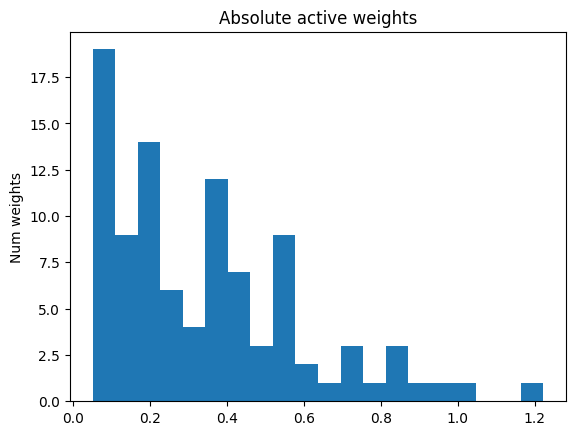

Epochs:  58%|█████████████████████████████████████████████████████████████████▌                                               | 29/50 [00:55<00:37,  1.78s/it]

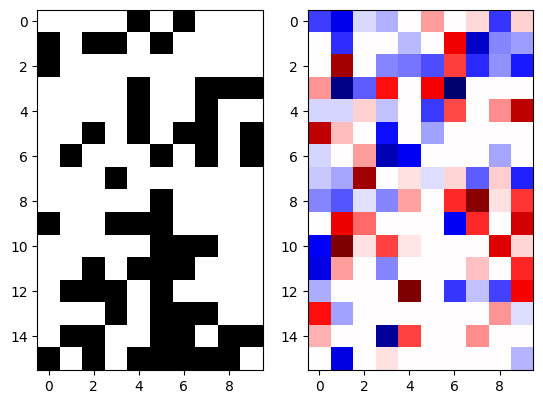

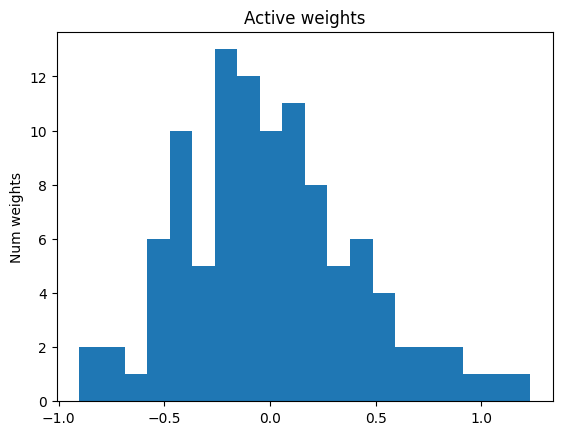

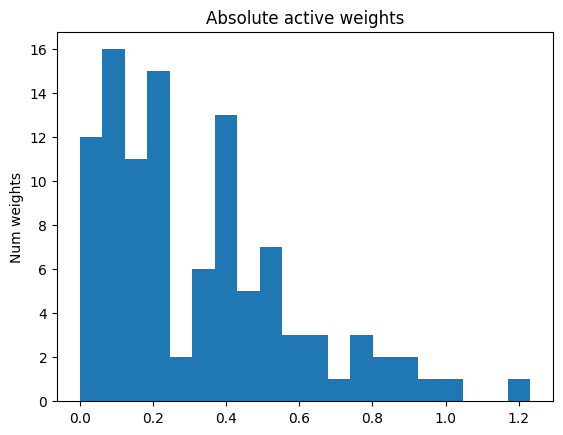

Epochs:  60%|███████████████████████████████████████████████████████████████████▊                                             | 30/50 [00:57<00:35,  1.80s/it]

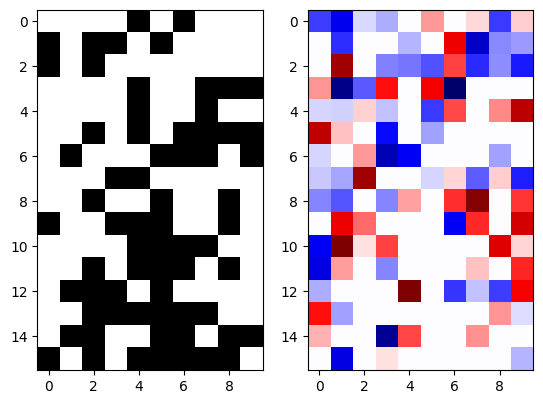

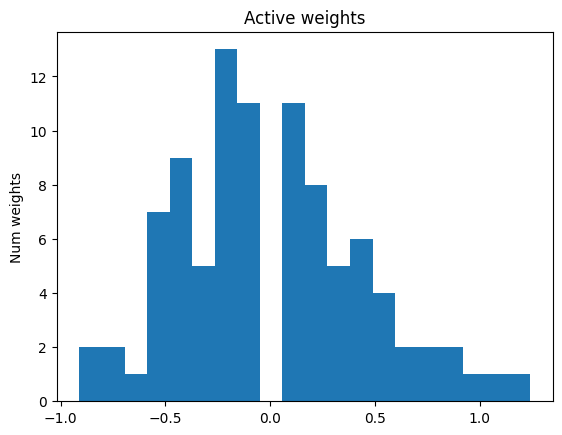

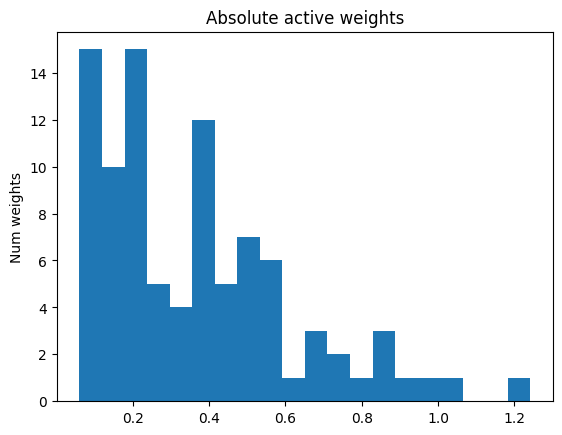

Epochs:  62%|██████████████████████████████████████████████████████████████████████                                           | 31/50 [00:59<00:34,  1.81s/it]

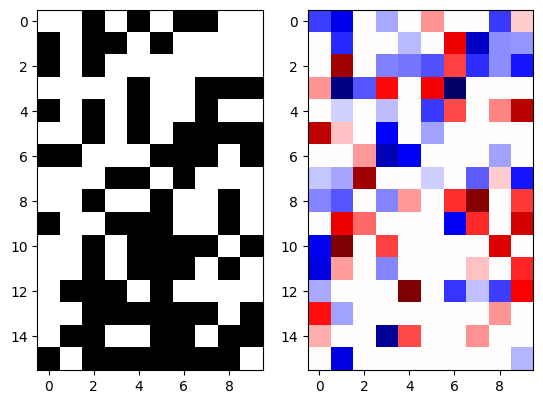

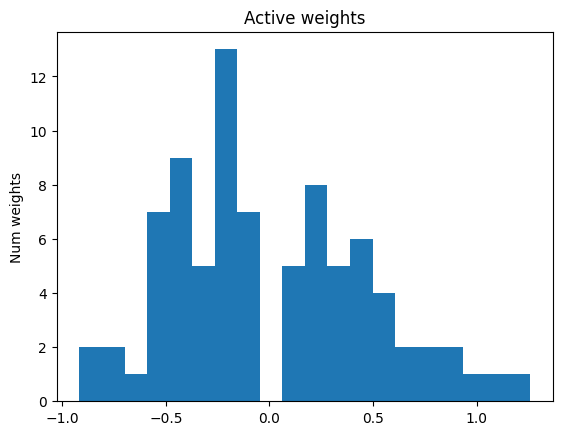

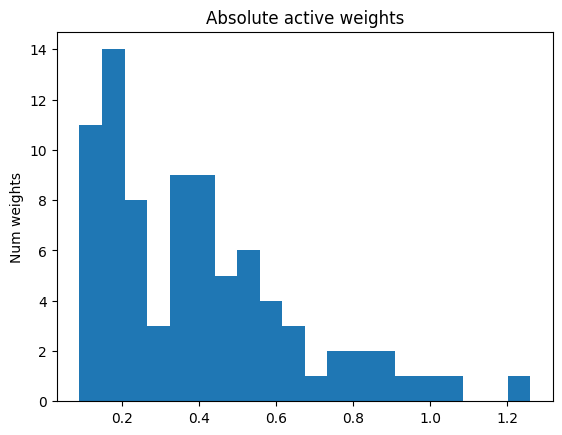

Epochs:  64%|████████████████████████████████████████████████████████████████████████▎                                        | 32/50 [01:01<00:32,  1.79s/it]

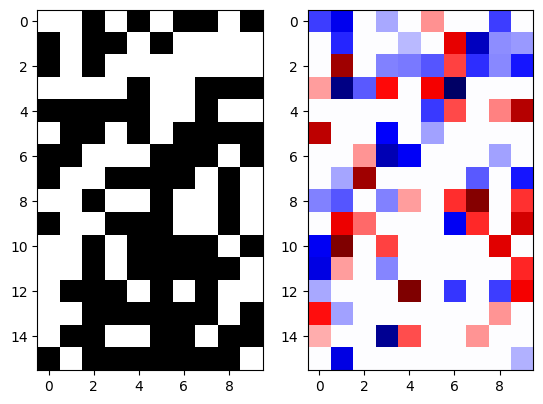

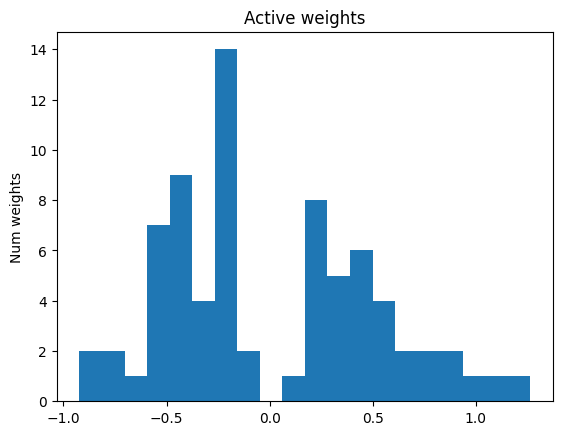

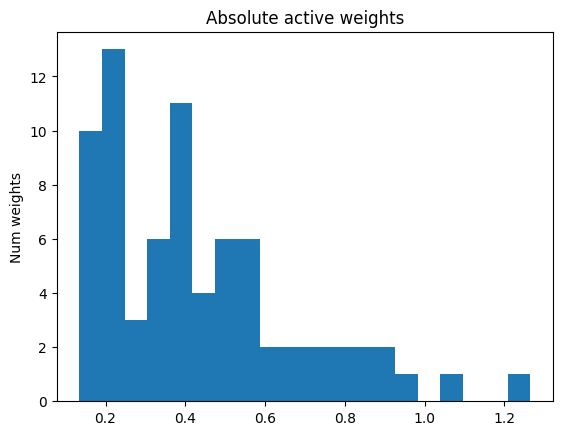

Epochs:  66%|██████████████████████████████████████████████████████████████████████████▌                                      | 33/50 [01:02<00:30,  1.77s/it]

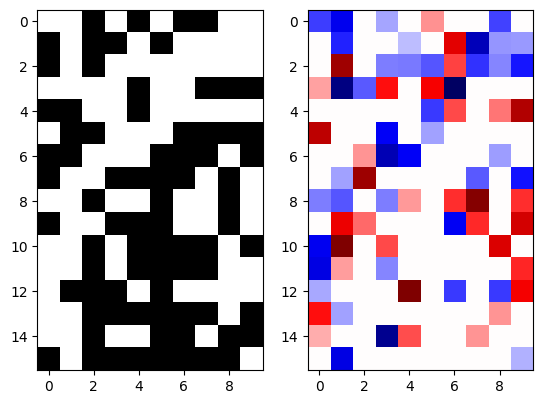

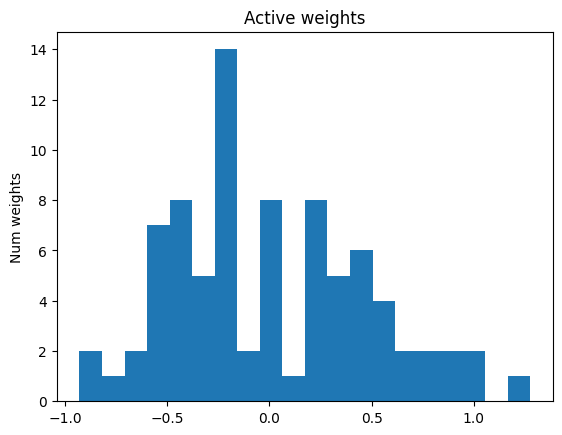

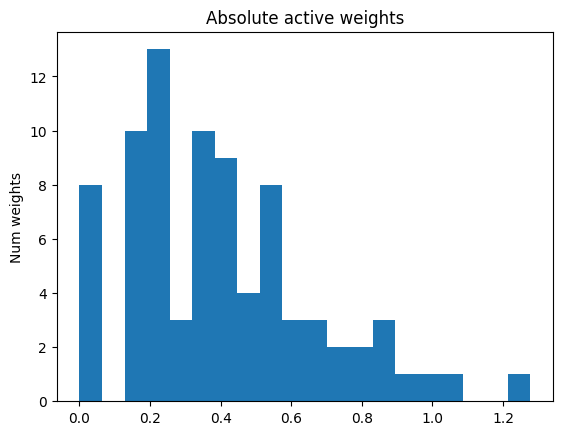

Epochs:  68%|████████████████████████████████████████████████████████████████████████████▊                                    | 34/50 [01:04<00:28,  1.77s/it]

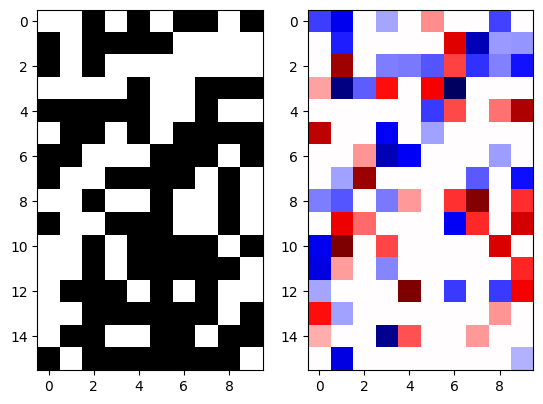

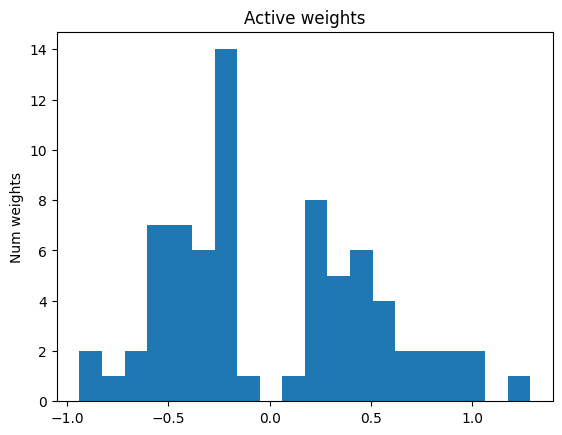

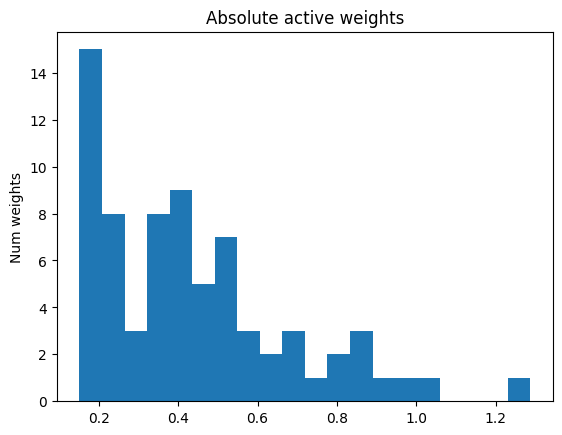

Epochs:  70%|███████████████████████████████████████████████████████████████████████████████                                  | 35/50 [01:06<00:26,  1.75s/it]

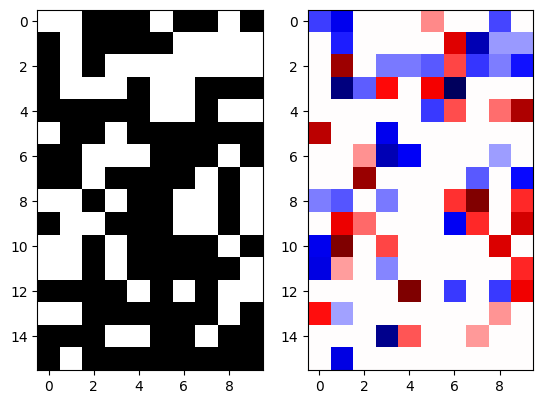

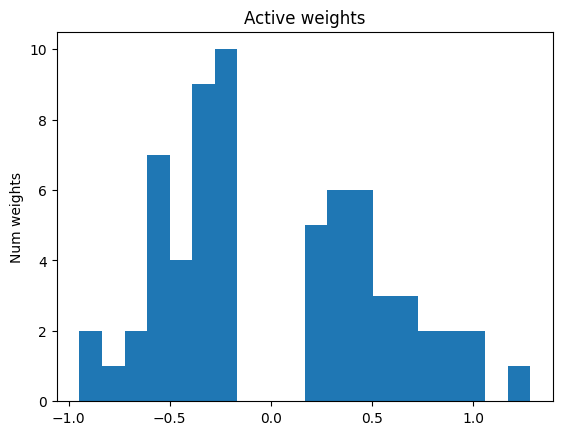

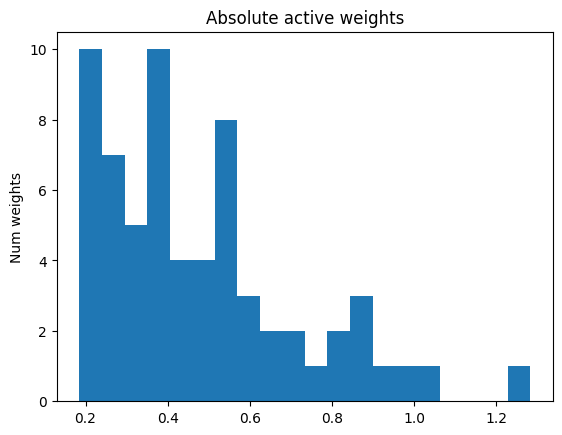

Epochs:  72%|█████████████████████████████████████████████████████████████████████████████████▎                               | 36/50 [01:08<00:25,  1.79s/it]

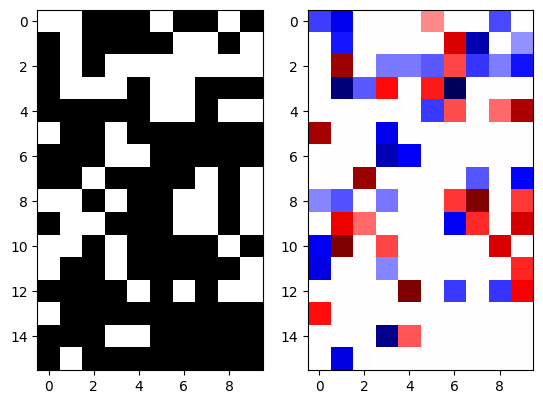

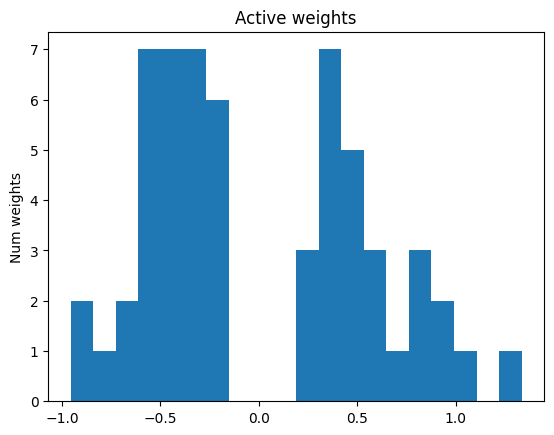

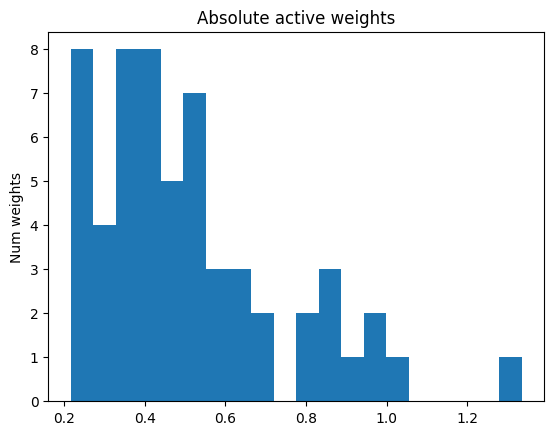

Epochs:  74%|███████████████████████████████████████████████████████████████████████████████████▌                             | 37/50 [01:10<00:23,  1.79s/it]

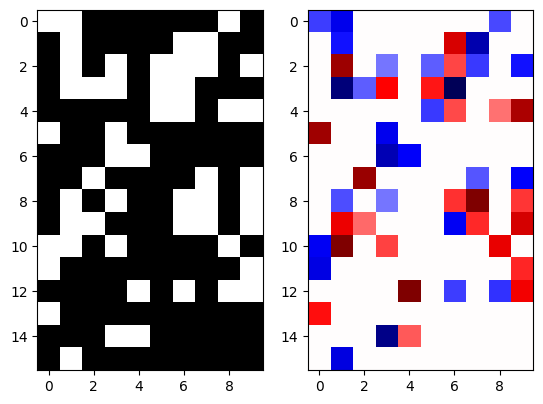

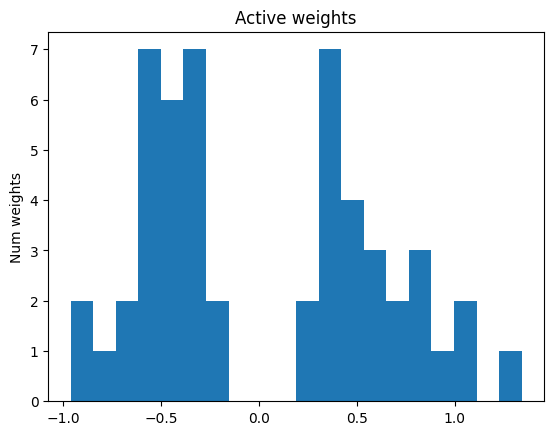

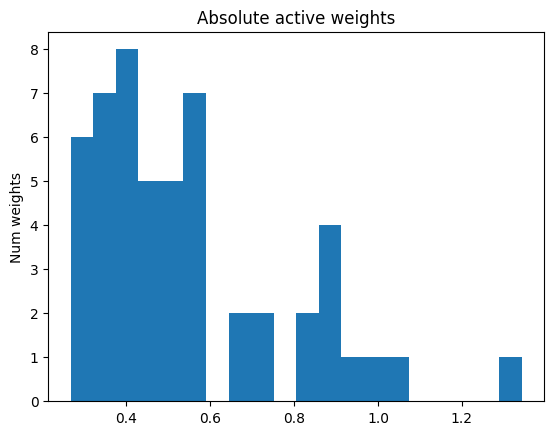

Epochs:  76%|█████████████████████████████████████████████████████████████████████████████████████▉                           | 38/50 [01:11<00:21,  1.79s/it]

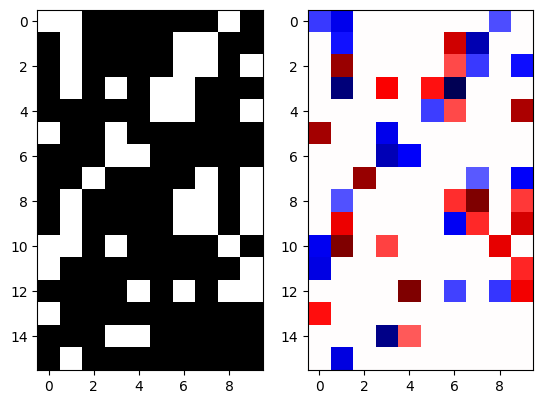

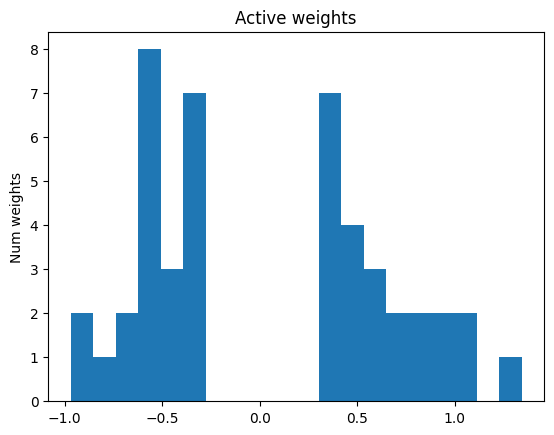

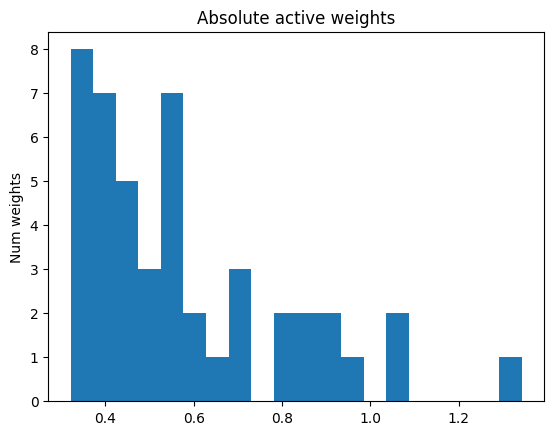

Epochs:  78%|████████████████████████████████████████████████████████████████████████████████████████▏                        | 39/50 [01:13<00:19,  1.80s/it]

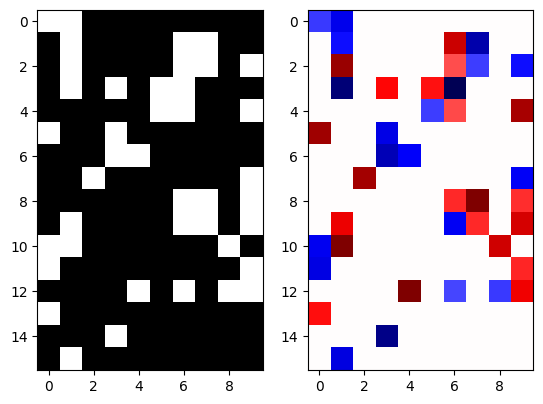

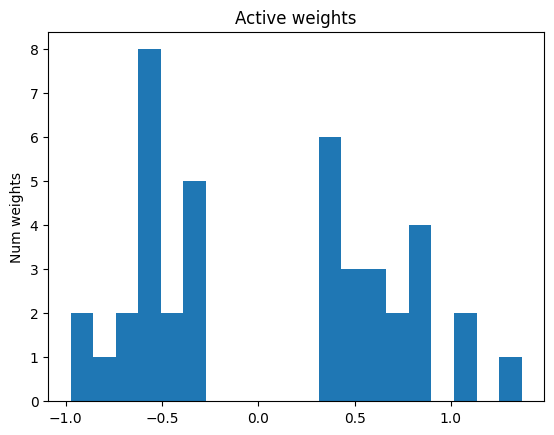

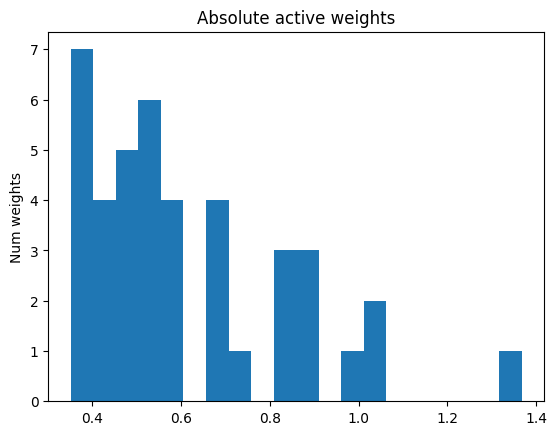

Epochs:  80%|██████████████████████████████████████████████████████████████████████████████████████████▍                      | 40/50 [01:15<00:18,  1.80s/it]

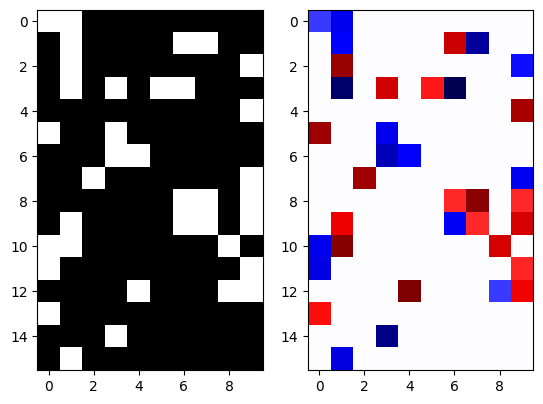

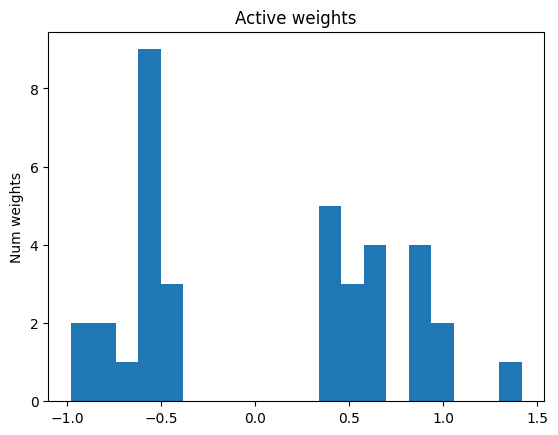

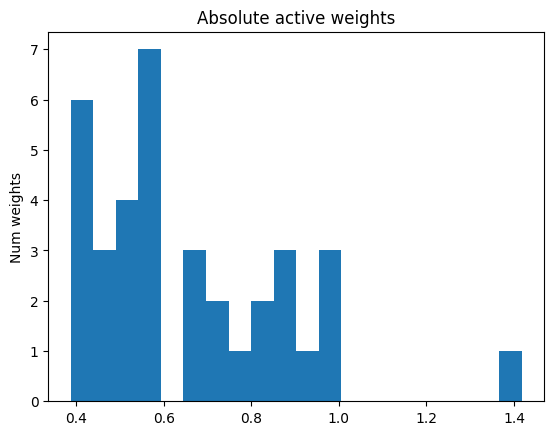

Epochs:  82%|████████████████████████████████████████████████████████████████████████████████████████████▋                    | 41/50 [01:17<00:17,  1.90s/it]

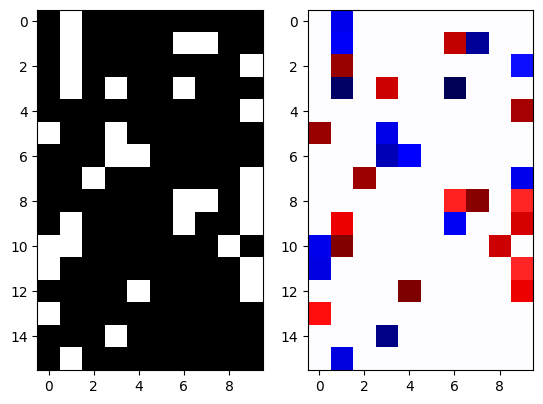

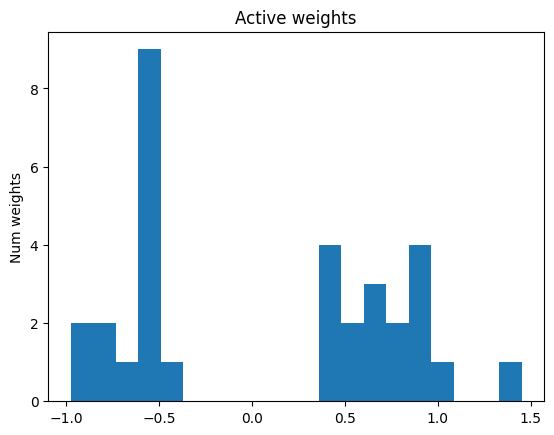

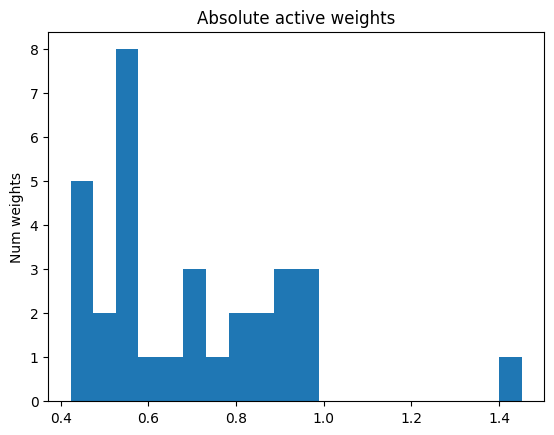

Epochs:  84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 42/50 [01:19<00:15,  1.91s/it]

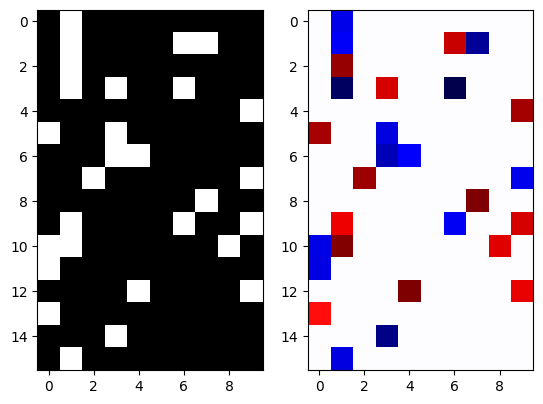

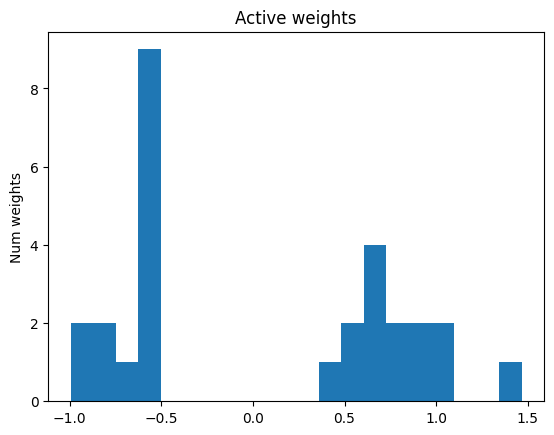

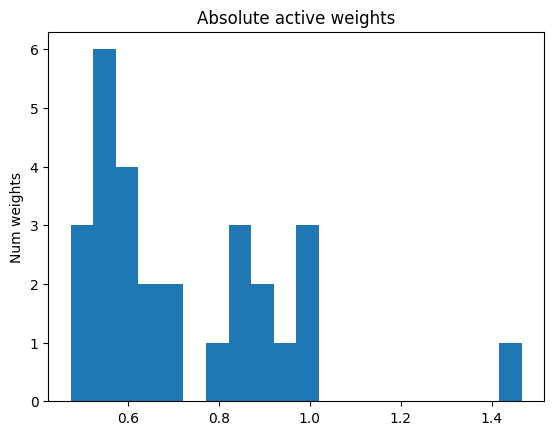

Epochs:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████▏               | 43/50 [01:21<00:13,  1.89s/it]

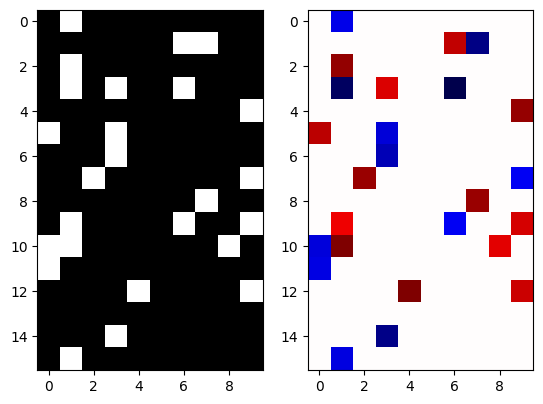

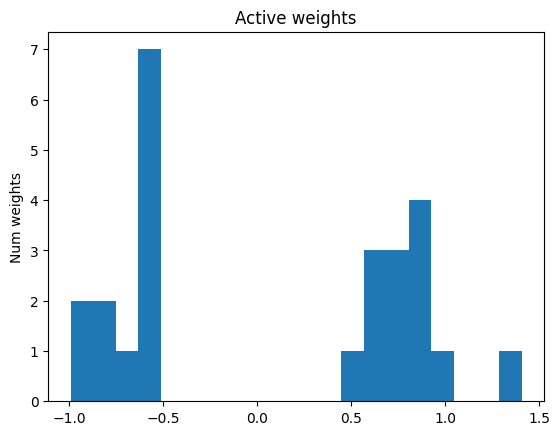

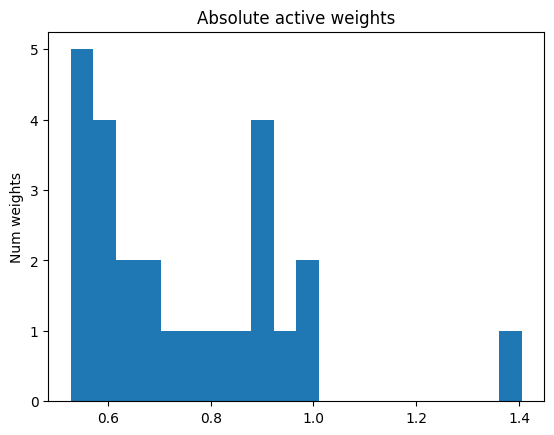

Epochs:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████▍             | 44/50 [01:23<00:11,  1.92s/it]

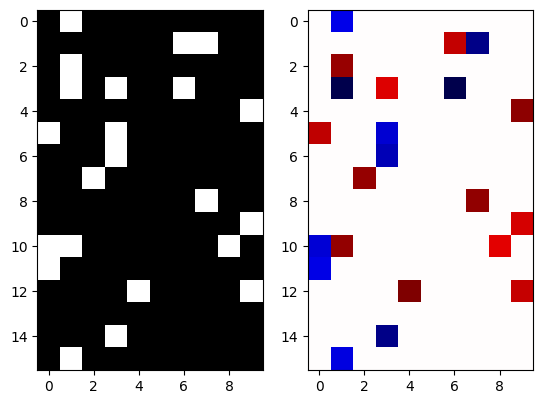

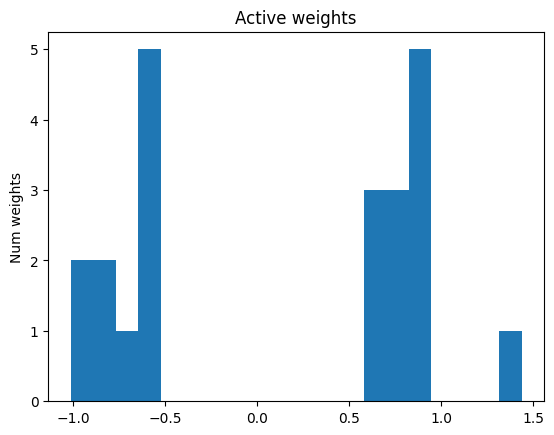

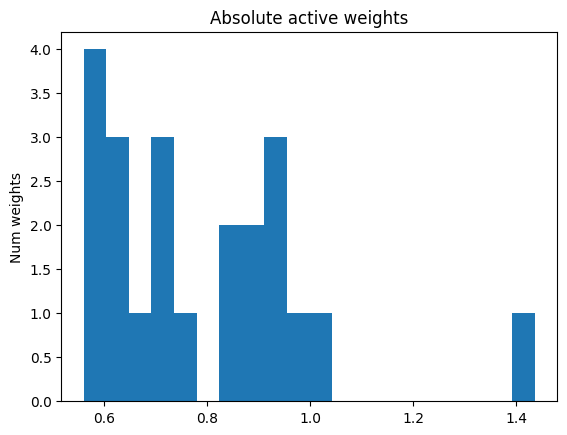

Epochs:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 45/50 [01:25<00:09,  1.88s/it]

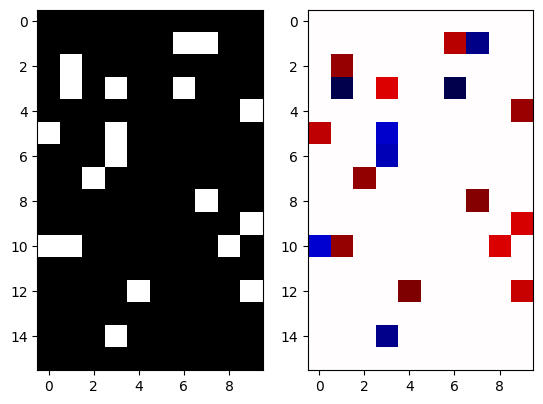

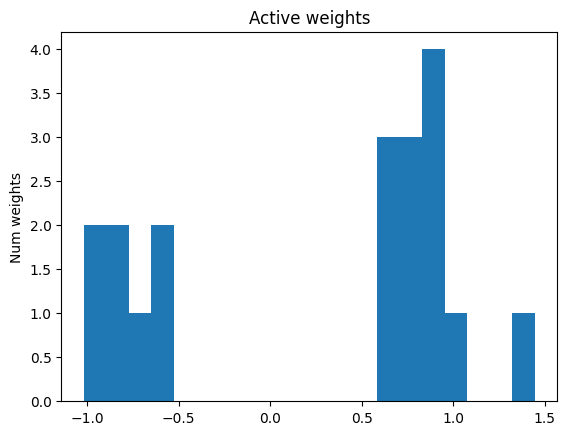

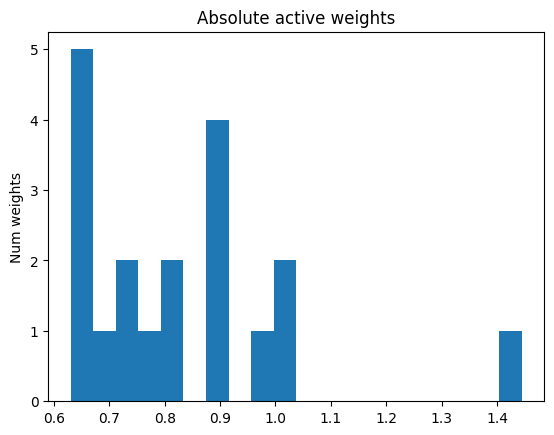

Epochs:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 46/50 [01:26<00:07,  1.87s/it]

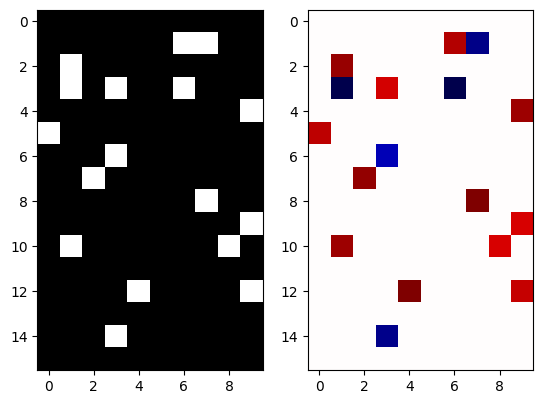

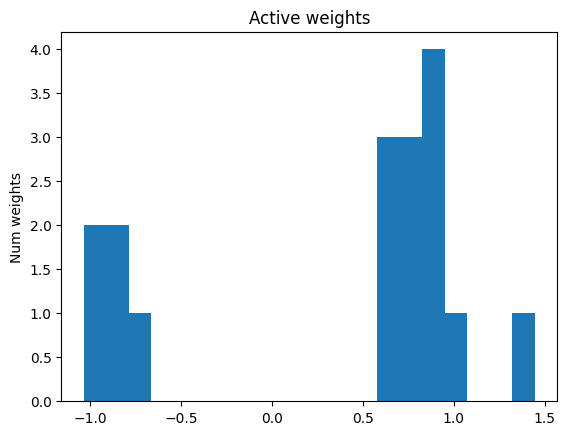

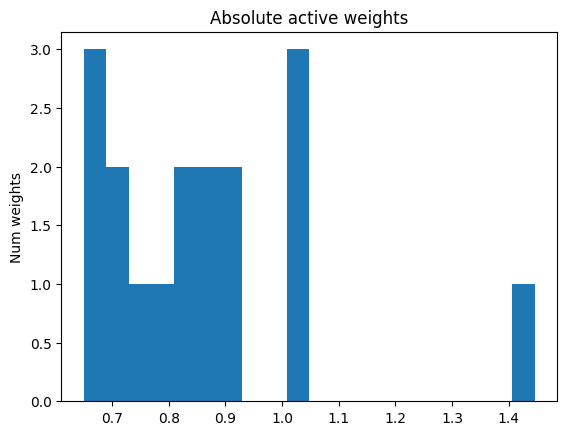

Epochs:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 47/50 [01:28<00:05,  1.84s/it]

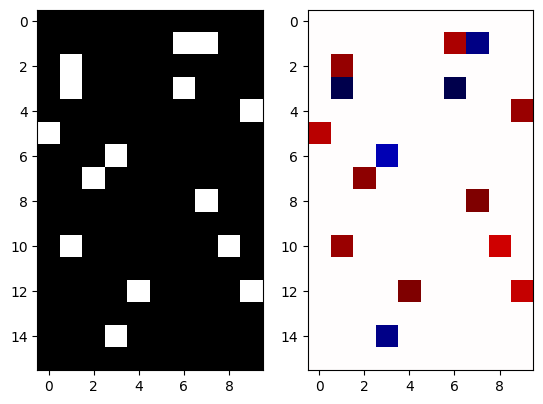

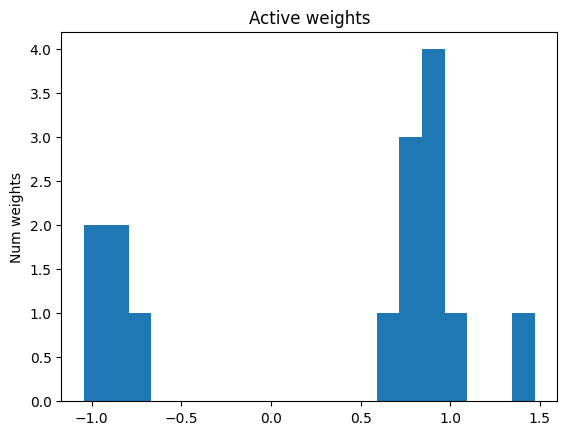

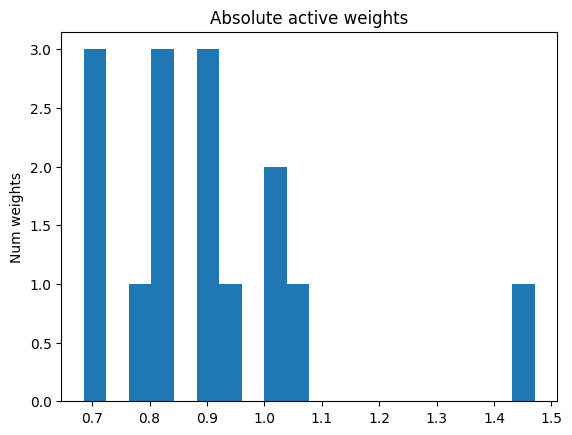

Epochs:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 48/50 [01:30<00:03,  1.82s/it]

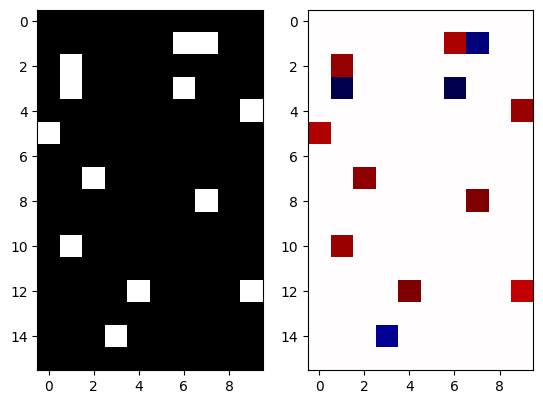

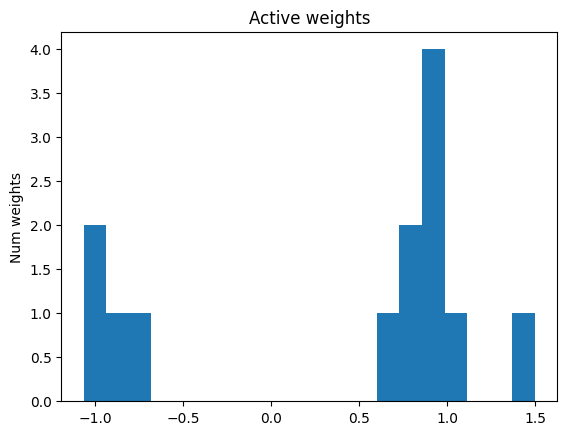

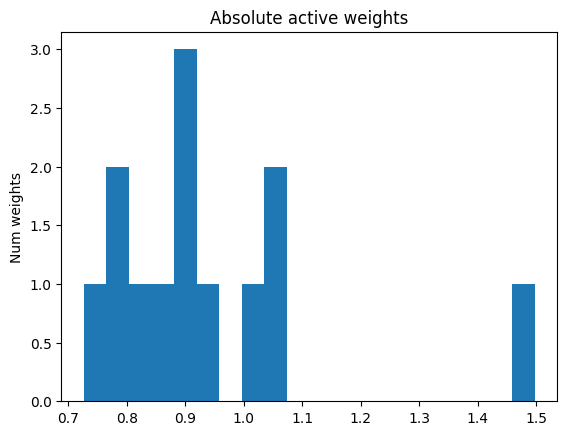

Epochs:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 49/50 [01:32<00:01,  1.80s/it]

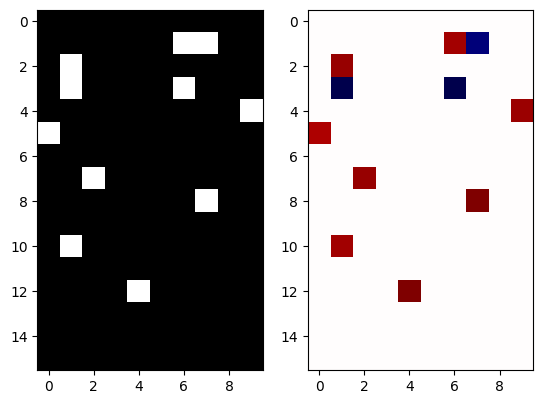

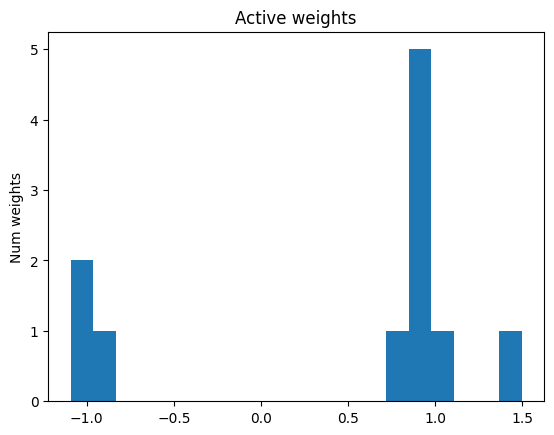

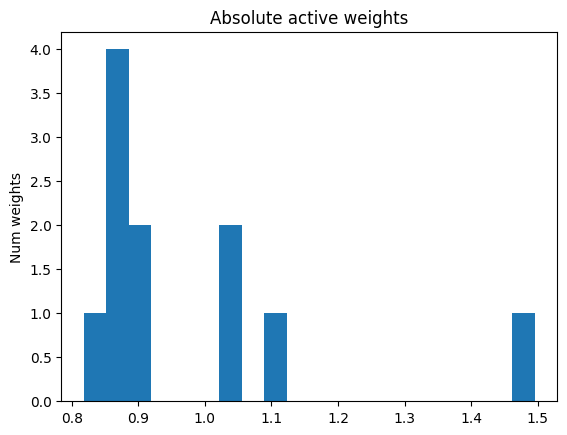

Epochs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:34<00:00,  1.88s/it]

done!


In [58]:
new_model = PruneGrowNetwork(gamma=0.1, init_density=0.5, num_training_iter=50)

new_train_losses_epoch, new_val_losses_epoch, new_test_df = full_train(
    new_model, train_dataloader, val_dataloader, test_dataloader,
    learning_rate = 1e-2, 
    plot=True, verbose=False
)